In [78]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [1]:
import json
import subprocess
import sys
from pathlib import Path
subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "seaborn"])

0

In [2]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   # optional; comment out if you prefer pure matplotlib

# ──────────────────────────────────────────────────────────────────────────
# 1.  Locate and parse every metrics.json
# ──────────────────────────────────────────────────────────────────────────
BASE_DIR = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/models")

records = []

for metrics_file in BASE_DIR.glob("*/*/metrics.json"):
    # metrics_file = …/models/{cancer}/{modality}/metrics.json
    cancer_type = metrics_file.parents[1].name     # folder two levels up
    modality    = metrics_file.parent.name         # folder one level up

    try:
        with metrics_file.open() as fp:
            metrics = json.load(fp)
        test_cidx = metrics.get("test_cidx")
    except (json.JSONDecodeError, OSError) as exc:
        print(f"⚠️  Skipping unreadable file {metrics_file}: {exc}")
        continue

    # In case the key is missing or the value is None
    if test_cidx is None:
        print(f"⚠️  No test_cidx in {metrics_file}")
        continue

    records.append(
        {
            "cancer":   cancer_type,
            "modality": modality,
            "test_cidx": float(test_cidx),
            "path":      str(metrics_file),   # helpful for debugging
        }
    )

if not records:
    raise RuntimeError("No metrics.json files were successfully read!")

df = pd.DataFrame.from_records(records)
print(f"Loaded {len(df):,} result files "
      f"({df['cancer'].nunique()} cancers, {df['modality'].nunique()} modalities).")
print(f"cancers included in analyses: {df['cancer'].unique()}")
# ──────────────────────────────────────────────────────────────────────────
# 2.  Make the box-plots
# ──────────────────────────────────────────────────────────────────────────
sns.set_style("whitegrid")         # nice defaults; comment out if using matplotlib only
sns.set_context("talk", font_scale=0.9)


Loaded 234 result files (26 cancers, 9 modalities).
cancers included in analyses: ['UCEC' 'STAD' 'BRCA' 'GBM' 'LUSC' 'THCA' 'LAML' 'KICH' 'ACC' 'CESC'
 'HNSC' 'OV' 'LIHC' 'ESCA' 'SKCM' 'UVM' 'PAAD' 'BLCA' 'LGG' 'UCS' 'LUAD'
 'SARC' 'COAD' 'KIRC' 'READ' 'KIRP']


In [3]:
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

# Hard-coded root for all plots
PLOT_DIR = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots")
PLOT_DIR.mkdir(parents=True, exist_ok=True)   # make sure it exists

def save_fig(name: str,
             subdir: str | None = None,
             dpi: int = 300,
             bbox_inches: str = "tight",
             **savefig_kwargs) -> Path:
    """
    Save the active Matplotlib figure under `PLOT_DIR` (or a child folder).
    
    Parameters
    ----------
    name : str
        File name, with or without extension. '.png' is added if omitted.
    subdir : str, optional
        Optional subfolder inside `PLOT_DIR` (e.g. cancer code, date).
    dpi : int
        Resolution of the saved image.
    bbox_inches : str
        Passed to plt.savefig; "tight" removes extra whitespace.
    **savefig_kwargs
        Any other plt.savefig keyword—e.g. transparent=True.
    
    Returns
    -------
    Path to the written file (useful for logging).
    """
    # Ensure extension
    if not Path(name).suffix:
        name += ".png"

    # Optional nested folder
    target_dir = PLOT_DIR / subdir if subdir else PLOT_DIR
    target_dir.mkdir(parents=True, exist_ok=True)

    # Timestamp to avoid overwriting
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{Path(name).stem}_{stamp}{Path(name).suffix}"
    fpath = target_dir / filename

    plt.savefig(fpath, dpi=dpi, bbox_inches=bbox_inches, **savefig_kwargs)
    print(f"[saved plot] {fpath}")
    return fpath

Scanning under: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/models

➡  234 result files loaded (26 cancers, 9 modalities)
[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/ModalitySummary_20250721_174939.pdf
[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/CancerTypeSummary_20250721_174941.pdf
[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/HighestCindex_20250721_174941.pdf
[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/SummedScores_20250721_174941.pdf
[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/MedianScores_20250721_174942.pdf


PosixPath('/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/MedianScores_20250721_174942.pdf')

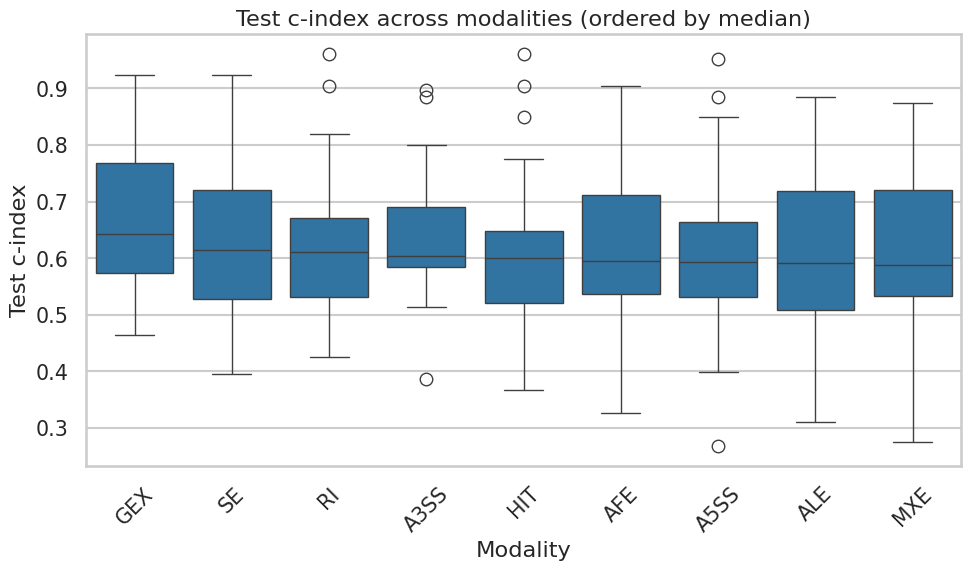

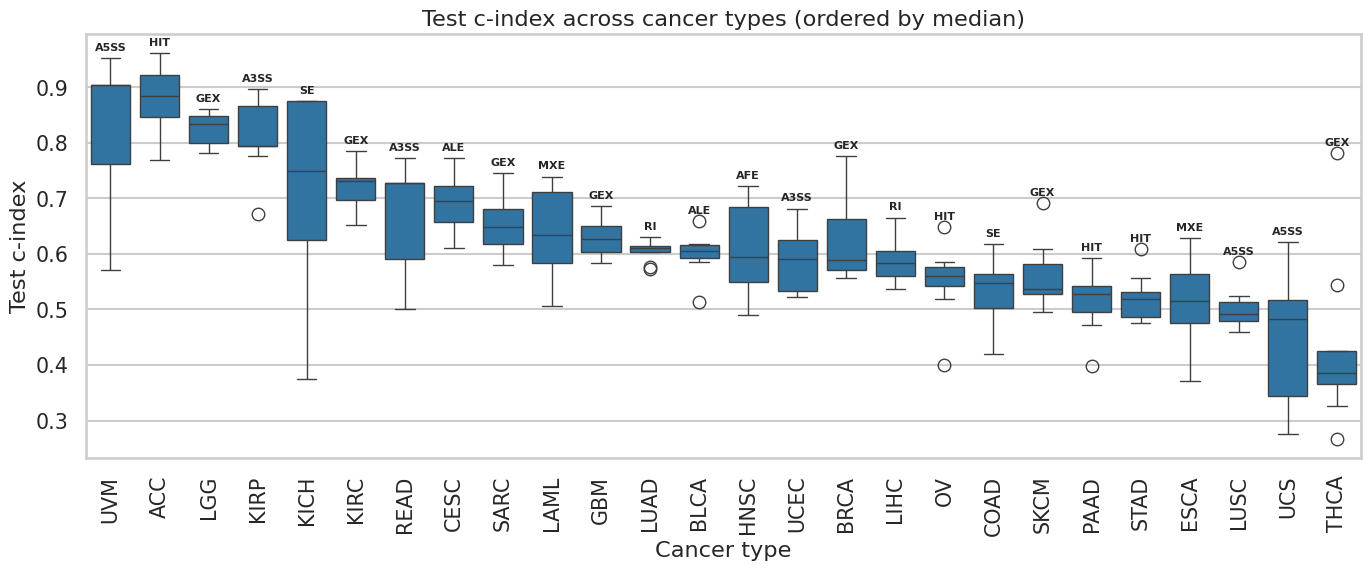

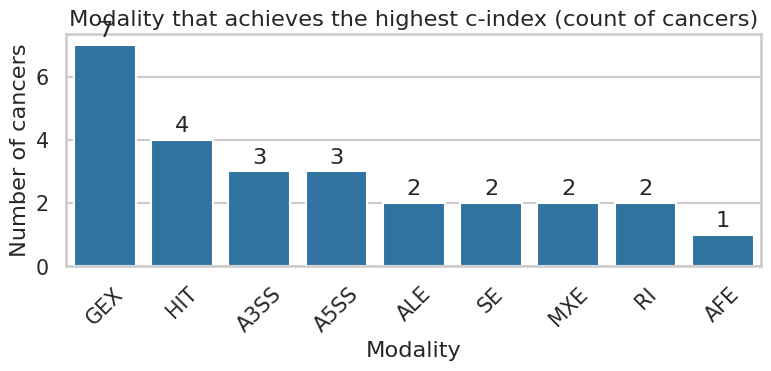

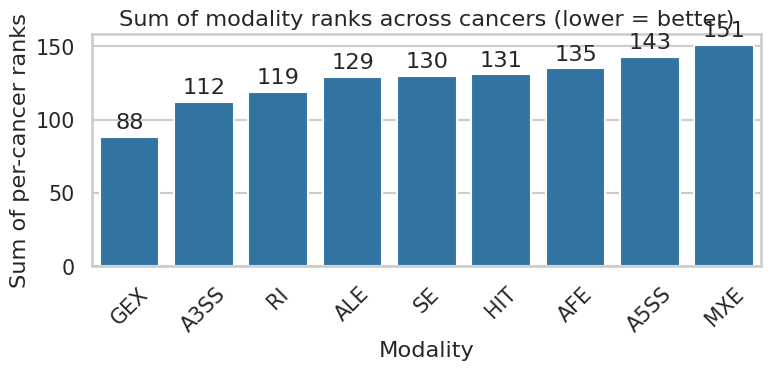

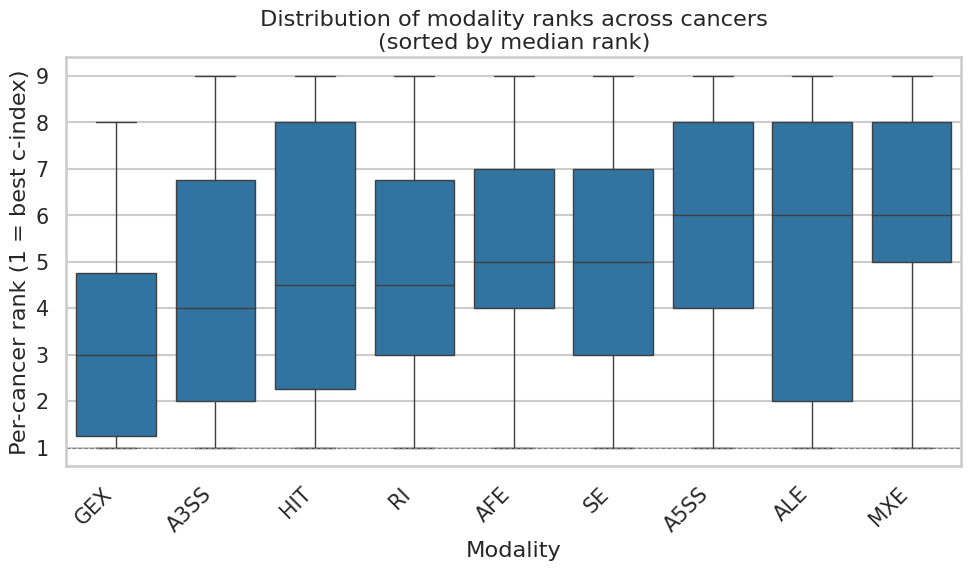

In [7]:
# %matplotlib inline             # or `%matplotlib widget` for interactive zoom

import json, subprocess, sys
from pathlib import Path

# ── 1. Ensure seaborn is available ───────────────────────────────
try:
    import seaborn as sns
except ModuleNotFoundError:
    print("Installing seaborn …")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "seaborn"])
    import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt

# ── 2. Point to the directory that actually holds your runs ─────
# CHANGE THIS if your files are really under /projectnb2/…
BASE_DIR = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/models")
# Example of alternative:
# BASE_DIR = Path("/projectnb2/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/models")

print(f"Scanning under: {BASE_DIR}")

# ── 3. Collect metrics.json files (recursive) ────────────────────
records = []
for metrics_file in BASE_DIR.rglob("metrics.json"):
    try:
        cancer   = metrics_file.parents[1].name   # {cancer}/{modality}/metrics.json
        modality = metrics_file.parent.name

        with metrics_file.open() as fp:
            metrics = json.load(fp)

        test_cidx = metrics.get("test_cidx")
        if test_cidx is None:
            continue

        records.append(
            {"cancer": cancer,
             "modality": modality,
             "test_cidx": float(test_cidx)}
        )
    except Exception as exc:
        print(f"⚠️  skipping {metrics_file}: {exc}")

df = pd.DataFrame(records)
print(f"\n➡  {len(df)} result files loaded "
      f"({df['cancer'].nunique()} cancers, {df['modality'].nunique()} modalities)")

if df.empty:
    raise RuntimeError("No data found – double-check BASE_DIR")

import seaborn as sns
sns.set_style("whitegrid"); sns.set_context("talk", font_scale=0.9)

# ── determine sort order by median ──────────────────────────────
order_mod = (
    df.groupby("modality")["test_cidx"]
      .median()
      .sort_values(ascending=False)     # highest median first
      .index
)

order_can = (
    df.groupby("cancer")["test_cidx"]
      .median()
      .sort_values(ascending=False)
      .index
)

# ── box-plot: across modalities ─────────────────────────────────
fig_mod, ax_mod = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x="modality", y="test_cidx",
            order=order_mod,
            ax=ax_mod, linewidth=1)
ax_mod.set(title="Test c-index across modalities (ordered by median)",
           xlabel="Modality", ylabel="Test c-index")
ax_mod.tick_params(axis="x", rotation=45)
plt.tight_layout()
# plt.show()

save_fig("ModalitySummary.pdf")

# ── box-plot: across cancer types ───────────────────────────────
fig_can, ax_can = plt.subplots(figsize=(14, 6))
sns.boxplot(data=df, x="cancer", y="test_cidx",
            order=order_can,
            ax=ax_can, linewidth=1)

ax_can.set(title="Test c-index across cancer types (ordered by median)",
           xlabel="Cancer type", ylabel="Test c-index")
ax_can.tick_params(axis="x", rotation=90)

# ▸ annotate: show which modality produced the max c-index per cancer
y_offset = 0.01                    # lift labels a bit above the whisker
for xpos, cancer in enumerate(order_can):
    cancer_slice = df.loc[df["cancer"] == cancer]
    idx_best     = cancer_slice["test_cidx"].idxmax()
    best_val     = cancer_slice.loc[idx_best, "test_cidx"]
    best_modal   = cancer_slice.loc[idx_best, "modality"]
    ax_can.text(xpos, best_val + y_offset, best_modal,
                ha="center", va="bottom", fontsize=8, fontweight="bold")

plt.tight_layout()
# plt.show()

save_fig("CancerTypeSummary.pdf")

# ── bar-plot: winner counts, sorted descending ───────────────────────────
# 1. Which modality wins in each cancer?
best_rows = (
    df.loc[df.groupby("cancer")["test_cidx"].idxmax()]   # one max row per cancer
)

best_count = (
    best_rows["modality"]
      .value_counts()
      .sort_values(ascending=False)      # ← sort by frequency ↓
)

# 2. Plot
fig_bar, ax_bar = plt.subplots(figsize=(8, 4))
sns.barplot(x=best_count.index, y=best_count.values, ax=ax_bar)
ax_bar.set(
    title="Modality that achieves the highest c-index (count of cancers)",
    xlabel="Modality",
    ylabel="Number of cancers"
)
ax_bar.bar_label(ax_bar.containers[0], padding=3)        # add counts on bars
ax_bar.tick_params(axis="x", rotation=45)
plt.tight_layout()
# plt.show()

save_fig("HighestCindex.pdf")

# ── rank-sum plot: lower = better ──────────────────────────────────────
# 1. Rank modalities inside each cancer (highest c-index → rank 1)
df["rank"] = (
    df.groupby("cancer")["test_cidx"]
      .rank(method="min", ascending=False)
)

# 2. Sum the ranks over cancers
rank_sum = (
    df.groupby("modality")["rank"]
      .sum()
      .sort_values()              # ascending: best overall first
)

# 3. Plot
fig_rank, ax_rank = plt.subplots(figsize=(8, 4))
sns.barplot(x=rank_sum.index, y=rank_sum.values, ax=ax_rank,
            order=rank_sum.index)           # already sorted
ax_rank.set(
    title="Sum of modality ranks across cancers (lower = better)",
    xlabel="Modality",
    ylabel="Sum of per-cancer ranks"
)
ax_rank.bar_label(ax_rank.containers[0], padding=3)      # show numbers
ax_rank.tick_params(axis="x", rotation=45)
plt.tight_layout()
# plt.show()

save_fig("SummedScores.pdf")

# ── 1. Rank each modality inside each cancer  (1 = best) ───────────────
df["rank"] = (
    df.groupby("cancer")["test_cidx"]
      .rank(method="min", ascending=False)
)

# ── 2. Median rank per modality → ordering vector ──────────────────────
median_rank = (
    df.groupby("modality")["rank"]
      .median()
      .sort_values()             # lower median = better overall
)

order_mod_rank = median_rank.index     # modalities sorted by median rank

# ── 3. Box-plot of per-cancer ranks  ───────────────────────────────────
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="modality", y="rank",
            order=order_mod_rank, linewidth=1)
plt.axhline(1, ls="--", c="grey", lw=0.8)   # visual ‘perfect’ line (optional)
plt.xlabel("Modality")
plt.ylabel("Per-cancer rank (1 = best c-index)")
plt.title("Distribution of modality ranks across cancers\n(sorted by median rank)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
# plt.show()

save_fig("MedianScores.pdf")

In [7]:
import subprocess, sys, re
from pathlib import Path

def ensure(pkg):
    try:
        __import__(pkg)
    except ModuleNotFoundError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg])
        __import__(pkg)

ensure("pandas");       import pandas as pd
ensure("matplotlib");   import matplotlib.pyplot as plt
ensure("seaborn");      import seaborn as sns
ensure("upsetplot");    from upsetplot import UpSet, from_memberships
import re
gene_re = re.compile(r"(ENSG\d{11})")

BASE_SHAP  = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/shap")
CSV_NAME  = "shap_mean_abs.csv"   # adapt if your file has a different name
TOP_K     = 150                    # keep this many features per model
TOP_N_BAR = 15                    # bar-plot size


def grab_gene(raw):
    """Return ENSG00000… if present, else the original string."""
    m = gene_re.search(str(raw))
    return m.group(1) if m else str(raw)

shap_records = []

for csv_path in BASE_SHAP.rglob(CSV_NAME):
    cancer, modality = csv_path.parents[1].name, csv_path.parent.name
    try:
        # 1️⃣  read with pandas auto-detect
        df_raw = pd.read_csv(csv_path, engine="python")          # handles commas / tabs

        # 2️⃣  force at least two columns: feature (first) + shap (last)
        if df_raw.shape[1] < 2:
            raise ValueError("needs ≥2 columns (feature, shap)")
        df = df_raw.iloc[:, [0, -1]].copy()
        df.columns = ["feature", "shap"]

        # 3️⃣  numeric coercion of SHAP column
        df["shap"] = pd.to_numeric(df["shap"], errors="coerce")
        n_before = len(df)
        df = df.dropna(subset=["shap"])
        if len(df) < n_before:
            print(f"    ↳ {csv_path.name}: dropped {n_before-len(df)} non-numeric rows")

        # 4️⃣  gene extraction
        df["gene_id"] = df["feature"].apply(grab_gene)

        # 5️⃣  keep top-k
        top = df.nlargest(TOP_K, "shap")
        for rank, row in top.iterrows():
            shap_records.append({
                "cancer":   cancer,
                "modality": modality,
                "feature":  row["feature"],
                "gene_id":  row["gene_id"],
                "rank":     rank + 1,
                "shap_val": row["shap"],
            })

    except Exception as exc:
        print(f"⚠️  skipping {csv_path.relative_to(BASE_SHAP)} → {exc}")

shap_df = pd.DataFrame(shap_records)
print("SHAP loaded...")

SHAP loaded...


In [8]:
subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "mygene"])
import mygene

# ▸ function to add HGNC symbols to shap_df ─────────────────────────
def add_hgnc_symbols(df, ensembl_col="gene_id"):
    """
    Return a copy of `df` with a new `hgnc_symbol` column.
    Rows whose Ensembl IDs cannot be mapped keep NaN in that column.
    """
    mg = mygene.MyGeneInfo()
    
    # grab unique ENSG IDs that look legit
    unique_ensg = df[ensembl_col].str.match(r"^ENSG\d{11}$", na=False)
    ensg_list   = df.loc[unique_ensg, ensembl_col].unique().tolist()
    
    if not ensg_list:
        print("No ENSG IDs detected – skipping symbol lookup.")
        return df.assign(hgnc_symbol=np.nan)
    
    print(f"Querying MyGene.info for {len(ensg_list)} Ensembl IDs …")
    out = mg.querymany(ensg_list, scopes="ensembl.gene", fields="symbol", species="human")
    
    # build dict → quick lookup
    id2sym = {d["query"]: d.get("symbol") for d in out if not d.get("notfound")}
    
    df = df.copy()
    df["hgnc_symbol"] = df[ensembl_col].map(id2sym)
    return df

# ▸ apply right after `shap_df` is created ──────────────────────────
shap_df = add_hgnc_symbols(shap_df)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Querying MyGene.info for 10120 Ensembl IDs …


55 input query terms found no hit:	['ENSG00000233818', 'ENSG00000239665', 'ENSG00000223808', 'ENSG00000225489', 'ENSG00000237940', 'ENS


Aggregated 35,100 rows (26 cancers, 9 modalities)


/projectnb/evolution/zachpw/.conda/envs/survival_env_full/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/projectnb/evolution/zachpw/.conda/envs/survival_env_full/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation i

[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/top150Upset_20250818_104306.pdf


/scratch/9913427.1.b/ipykernel_257463/392526114.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=recurrent.head(TOP_N_BAR).index,


[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/top150Shap_20250818_104308.pdf
✓ Saved tidy table → top_k_shap_features.csv


<Figure size 1000x600 with 0 Axes>

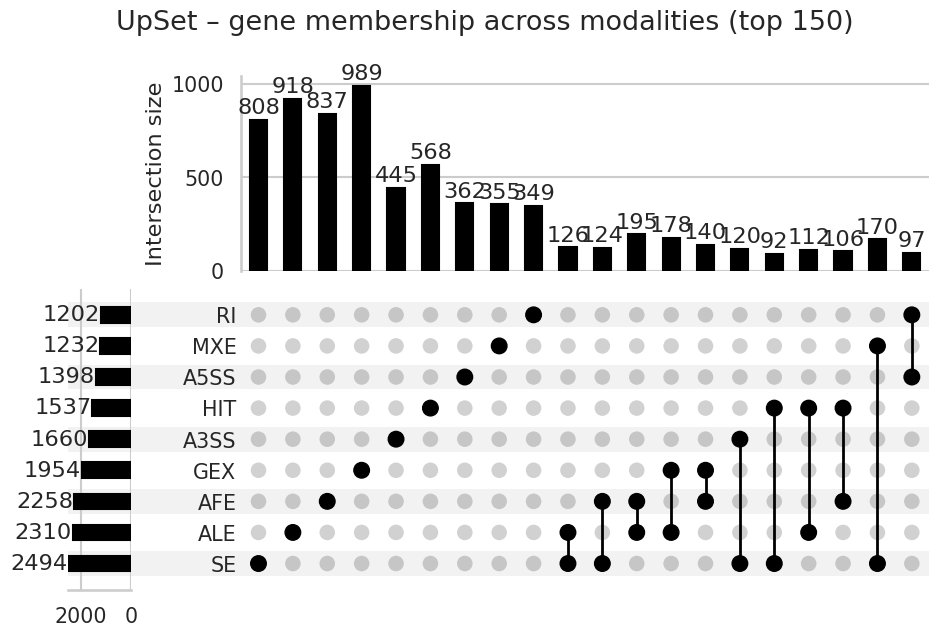

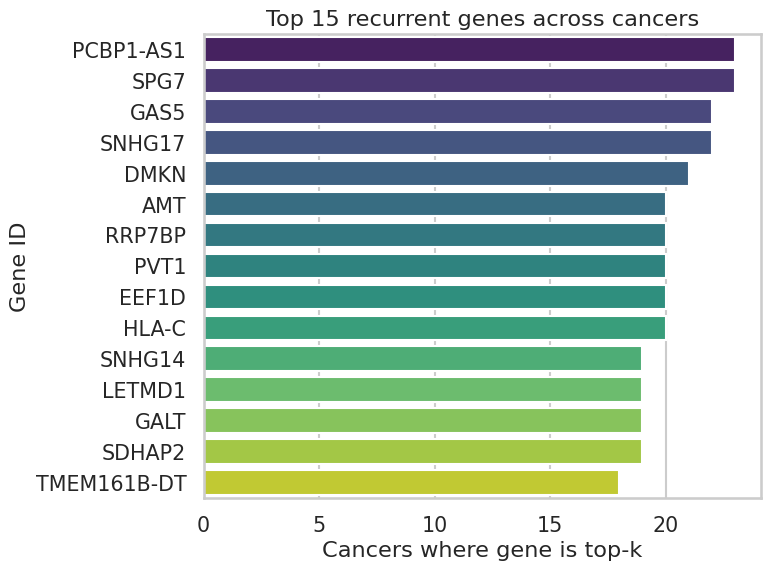

In [9]:
top_df = shap_df.copy()
if top_df.empty:
    raise RuntimeError("No SHAP CSVs found – check BASE_DIR / CSV_NAME.")

print(f"Aggregated {len(top_df):,} rows "
      f"({top_df.cancer.nunique()} cancers, {top_df.modality.nunique()} modalities)")

# ── visual 1: UpSet plot (gene × modality membership) ───────────────────
membership = (
    top_df.groupby(["hgnc_symbol", "modality"])
          .size()
          .unstack(fill_value=0)        # gene_id × modality bool matrix
          .astype(bool)
          .apply(lambda row: tuple(row.index[row].tolist()), axis=1)
)

plt.figure(figsize=(10, 6))
UpSet(from_memberships(membership), subset_size='count', show_counts=True,
      min_subset_size=90).plot()
plt.suptitle(f"UpSet – gene membership across modalities (top {TOP_K})")
# plt.show()

save_fig("top150Upset.pdf")


# ── visual 2: recurrent genes across cancers ────────────────────────────
recurrent = (top_df.groupby("hgnc_symbol")["cancer"]
                    .nunique()
                    .sort_values(ascending=False))

sns.set_style("whitegrid"); sns.set_context("talk", font_scale=0.9)
plt.figure(figsize=(8, 6))
sns.barplot(y=recurrent.head(TOP_N_BAR).index,
            x=recurrent.head(TOP_N_BAR).values,
            palette="viridis")
plt.xlabel("Cancers where gene is top-k")
plt.ylabel("Gene ID")
plt.title(f"Top {TOP_N_BAR} recurrent genes across cancers")
plt.tight_layout()
# plt.show()

save_fig("top150Shap.pdf")
# ── export tidy table for enrichment etc. ───────────────────────────────
top_df.to_csv("top_k_shap_features.csv", index=False)
print("✓ Saved tidy table → top_k_shap_features.csv")

n_models  mean_rank  median_rank  best_rank
hgnc_symbol                                             
EGFR                1     34.000         34.0         34
CD274               5     62.000         47.0          8
BRAF                8     65.500         53.0         46
PTEN                2     61.500         61.5         46
TP53                1     67.000         67.0         67
BRCA1              12     78.000         73.0         12
IDH1                1     79.000         79.0         79
KRAS                2     85.500         85.5         28
ERBB2               8     88.875        104.0         12
NPM1                4     98.500        106.5         31

[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/top150MajorGenes_20250818_104318.pdf


PosixPath('/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/top150MajorGenes_20250818_104318.pdf')

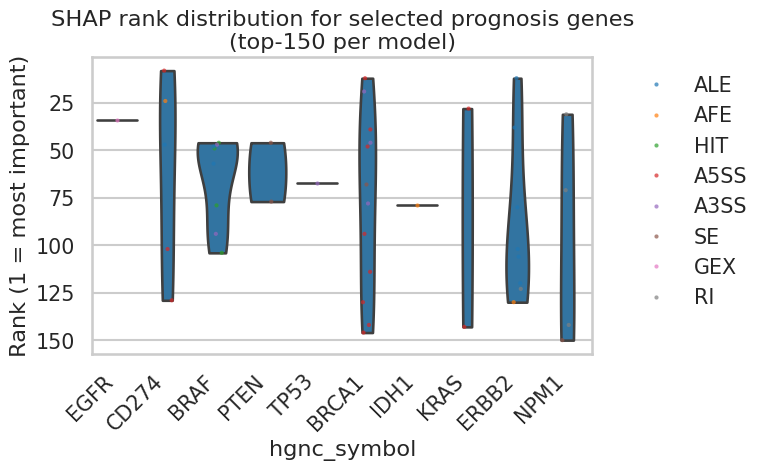

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣  Tell me which identifier column to use
ID_COL = "hgnc_symbol"          # ← use "gene_id" if symbols not available

# 2️⃣  Pick the genes you care about  (case-insensitive for symbols)
genes_of_interest = [
    # canonical tumour suppressors / oncogenes
    "TP53", "KRAS", "BRAF", "PIK3CA", "PTEN", "MYC",
    # context-specific or pathway drivers
    "EGFR", "ERBB2", "ALK", "FLT3", "NPM1",
    # DNA-repair & BRCA axis
    "BRCA1", "BRCA2",
    # metabolic mutations
    "IDH1", "IDH2",
    # TERT promoter / telomerase
    "TERT",
    # immune checkpoint / micro-environment
    "CD274"   # PD-L1
]

# harmonise case for symbols
if ID_COL == "hgnc_symbol":
    shap_df[ID_COL] = shap_df[ID_COL].str.upper()

shap_sub = shap_df[shap_df[ID_COL].isin([g.upper() for g in genes_of_interest])]

if shap_sub.empty:
    raise ValueError("None of the chosen genes appear in the SHAP top-k tables.")

# 3️⃣  Summary table
summary = (
    shap_sub.groupby(ID_COL)
            .agg(n_models = ("rank", "size"),
                 mean_rank = ("rank", "mean"),
                 median_rank = ("rank", "median"),
                 best_rank = ("rank", "min"))
            .sort_values("median_rank")
)

display(summary)

# 4️⃣  Violin + strip plot of ranks
sns.set_style("whitegrid"); sns.set_context("talk", font_scale=0.9)
plt.figure(figsize=(8, 5))
sns.violinplot(data=shap_sub, x=ID_COL, y="rank", order=summary.index,
               inner=None, cut=0)
sns.stripplot(data=shap_sub, x=ID_COL, y="rank", order=summary.index,
              hue="modality", dodge=False, size=3, alpha=0.7)
plt.gca().invert_yaxis()          # rank 1 at top
plt.ylabel("Rank (1 = most important)")
plt.title(f"SHAP rank distribution for selected prognosis genes\n(top-{TOP_K} per model)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
# plt.show()

save_fig("top150MajorGenes.pdf")


234 model runs parsed (26 cancers, 9 modalities)


cancer modality   MADfeatures
count     234      234    234.000000
unique     26        9           NaN
top      UCEC      GEX           NaN
freq        9       26           NaN
mean      NaN      NaN   4303.418803
std       NaN      NaN   3455.391548
min       NaN      NaN    500.000000
25%       NaN      NaN   1000.000000
50%       NaN      NaN   4000.000000
75%       NaN      NaN   7500.000000
max       NaN      NaN  10000.000000

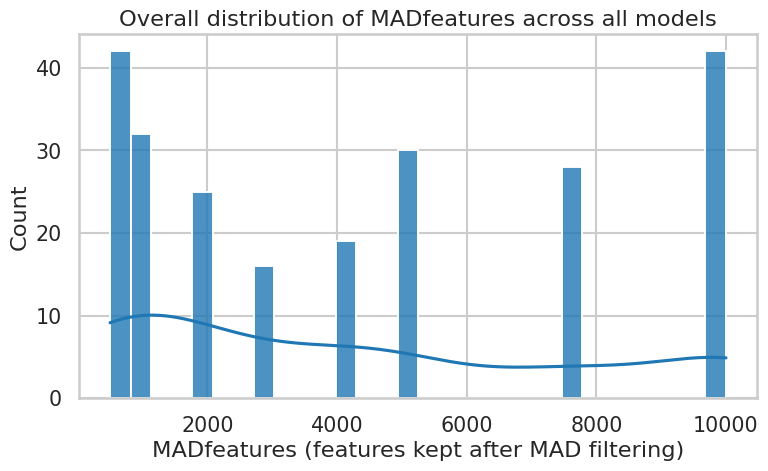

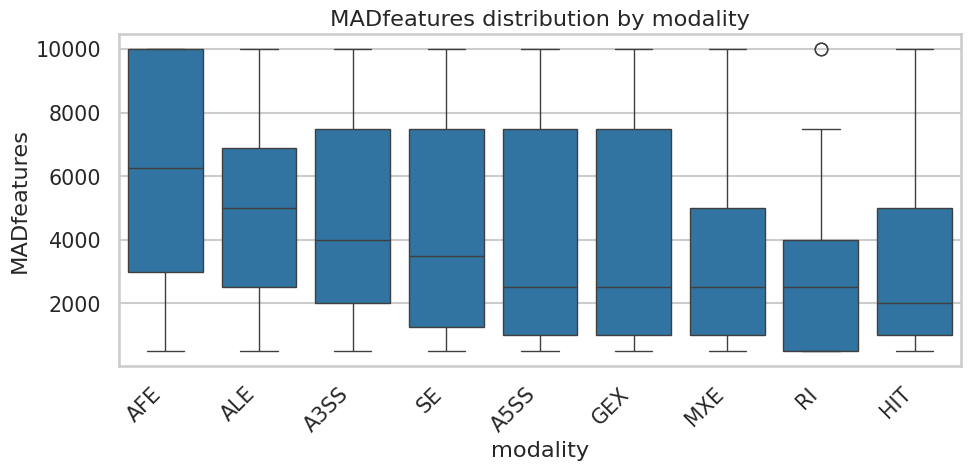

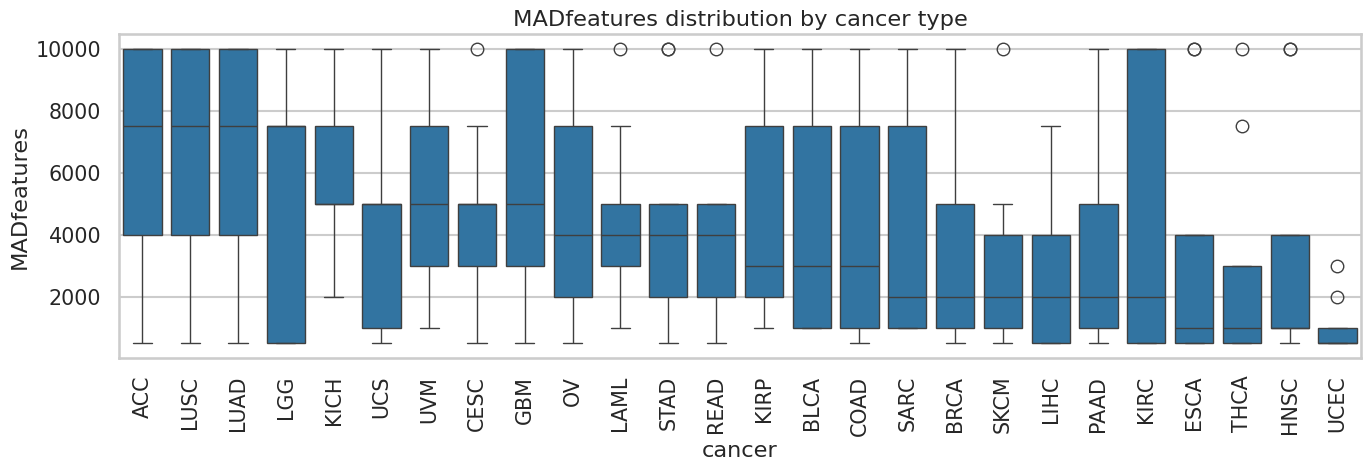

In [11]:
import json, subprocess, sys, warnings
from pathlib import Path
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────
# 1.  Collect MADfeatures values
BASE_MET = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/models")
records  = []

for mj in BASE_MET.glob("*/*/metrics.json"):
    cancer, modality = mj.parents[1].name, mj.parent.name
    try:
        with mj.open() as fp:
            meta = json.load(fp)
        k = meta["params"].get("MADfeatures")
        if k is None:
            raise KeyError("MADfeatures missing")
        records.append({"cancer": cancer, "modality": modality, "MADfeatures": int(k)})
    except Exception as e:
        warnings.warn(f"skip {mj.relative_to(BASE_MET)} → {e}")

mad_df = pd.DataFrame(records)
if mad_df.empty:
    raise RuntimeError("No MADfeatures found—check path or file schema.")

print(f"{len(mad_df):,} model runs parsed "
      f"({mad_df.cancer.nunique()} cancers, {mad_df.modality.nunique()} modalities)")
display(mad_df.describe(include='all'))

# ───────────────────────────────────────────────────────────────
# 2.  Plot overall histogram
sns.set_style("whitegrid"); sns.set_context("talk", font_scale=0.9)

plt.figure(figsize=(8,5))
sns.histplot(mad_df["MADfeatures"], bins=30, kde=True, alpha=0.8)
plt.xlabel("MADfeatures (features kept after MAD filtering)")
plt.title("Overall distribution of MADfeatures across all models")
plt.tight_layout(); plt.show()

# ───────────────────────────────────────────────────────────────
# 3.  Box-plot by modality
plt.figure(figsize=(10,5))
order_mod = (mad_df.groupby("modality")["MADfeatures"]
                     .median()
                     .sort_values(ascending=False).index)
sns.boxplot(data=mad_df, x="modality", y="MADfeatures", order=order_mod)
plt.xticks(rotation=45, ha="right")
plt.title("MADfeatures distribution by modality")
plt.tight_layout(); plt.show()

# ───────────────────────────────────────────────────────────────
# 4.  Box-plot by cancer type
plt.figure(figsize=(14,5))
order_can = (mad_df.groupby("cancer")["MADfeatures"]
                     .median()
                     .sort_values(ascending=False).index)
sns.boxplot(data=mad_df, x="cancer", y="MADfeatures", order=order_can)
plt.xticks(rotation=90)
plt.title("MADfeatures distribution by cancer type")
plt.tight_layout(); plt.show()

In [12]:
# How many distinct (cancer, modality) combinations have metrics.json ?
n_pairs = shap_df[["cancer", "modality"]].drop_duplicates().shape[0]
print(f"Unique cancer-modality pairs: {n_pairs}")
print("\nModalities per cancer:")
display(shap_df.groupby("cancer")["modality"].nunique().sort_values(ascending=False))

print("\nCancers per modality:")
display(shap_df.groupby("modality")["cancer"].nunique().sort_values(ascending=False))

Unique cancer-modality pairs: 234

Modalities per cancer:


cancer
ACC     9
BLCA    9
UCS     9
UCEC    9
THCA    9
STAD    9
SKCM    9
SARC    9
READ    9
PAAD    9
OV      9
LUSC    9
LUAD    9
LIHC    9
LGG     9
LAML    9
KIRP    9
KIRC    9
KICH    9
HNSC    9
GBM     9
ESCA    9
COAD    9
CESC    9
BRCA    9
UVM     9
Name: modality, dtype: int64


Cancers per modality:


modality
A3SS    26
A5SS    26
AFE     26
ALE     26
GEX     26
HIT     26
MXE     26
RI      26
SE      26
Name: cancer, dtype: int64

In [13]:
subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gseapy"])

import pandas as pd
import gseapy as gp

# 1. ─ Load SHAP table (tidy format we saved earlier)
shap_df = pd.read_csv("top_k_shap_features.csv")

# 2. ─ Select genes you want to test
TOP_RANK  = 100                      # top-k per model
query     = shap_df["rank"] <= TOP_RANK
genes     = (shap_df.loc[query, "hgnc_symbol"]
                     .dropna()
                     .str.upper()   # Enrichr expects upper-case symbols
                     .unique()
                     .tolist())

print(f"Submitting {len(genes)} unique genes to Enrichr…")

# 3.1 ─ Run Enrichr (GO BP as example; pick any collection you like)
enrGOBP = gp.enrichr(
    gene_list   = genes,
    gene_sets   = "GO_Biological_Process_2023",
    organism    = "Human",
    outdir      = None,             # no files on disk
    cutoff      = 0.05,             # adjust-P threshold
)

# 4.1 ─ Show top results
cols = ["Term", "Adjusted P-value", "Overlap", "Combined Score"]
display(enrGOBP.results.sort_values("Adjusted P-value").head(5)[cols])

# 3.2 ─ Run Enrichr (GO BP as example; pick any collection you like)
enrKEGG = gp.enrichr(gene_list=genes, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff      = 0.05
                )

# 4.2 ─ Show top results
cols = ["Term", "Adjusted P-value", "Overlap", "Combined Score"]
display(enrKEGG.results.sort_values("Adjusted P-value").head(5)[cols])

# 3.3 ─ Run Enrichr (GO BP as example; pick any collection you like)
enrHALL = gp.enrichr(gene_list=genes, # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff      = 0.05
                )

# 4.3 ─ Show top results
cols = ["Term", "Adjusted P-value", "Overlap", "Combined Score"]
display(enrHALL.results.sort_values("Adjusted P-value").head(5)[cols])

Submitting 8161 unique genes to Enrichr…


Term  Adjusted P-value  \
0  Regulation Of Small GTPase Mediated Signal Tra...          0.002568   
1                   DNA Damage Response (GO:0006974)          0.006257   
2                            DNA Repair (GO:0006281)          0.006257   
3                  Cell-Matrix Adhesion (GO:0007160)          0.025739   
4  Regulation Of Anatomical Structure Morphogenes...          0.025739   

   Overlap  Combined Score  
0   75/118       37.010935  
1  201/384       20.642468  
2  157/291       21.514641  
3   66/109       23.786213  
4   75/127       22.352484

Term  Adjusted P-value  Overlap  Combined Score
0        Tyrosine metabolism          0.152767    25/36       25.266680
10            Bladder cancer          0.208912    25/41       11.208190
9                  Apoptosis          0.208912   73/142        7.717144
7   Linoleic acid metabolism          0.208912    19/29       14.011061
6             Focal adhesion          0.208912  100/201        7.343886

Term  Adjusted P-value  Overlap  \
0  Epithelial Mesenchymal Transition      8.502881e-09  126/200   
1                         Myogenesis      1.648621e-06  119/200   
2             Estrogen Response Late      5.017737e-06  117/200   
3                  KRAS Signaling Up      7.374178e-04  109/200   
4                        Coagulation      2.563592e-03   77/138   

   Combined Score  
0       56.082663  
1       35.515752  
2       30.934840  
3       17.018404  
4       15.207419

[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/enrGOBP150_bar_20250818_104718.pdf
[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/enrGOBP150_dot_20250818_104719.pdf
[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/enrHall150_bar_20250818_104719.pdf
[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/enrHall150_dot_20250818_104719.pdf


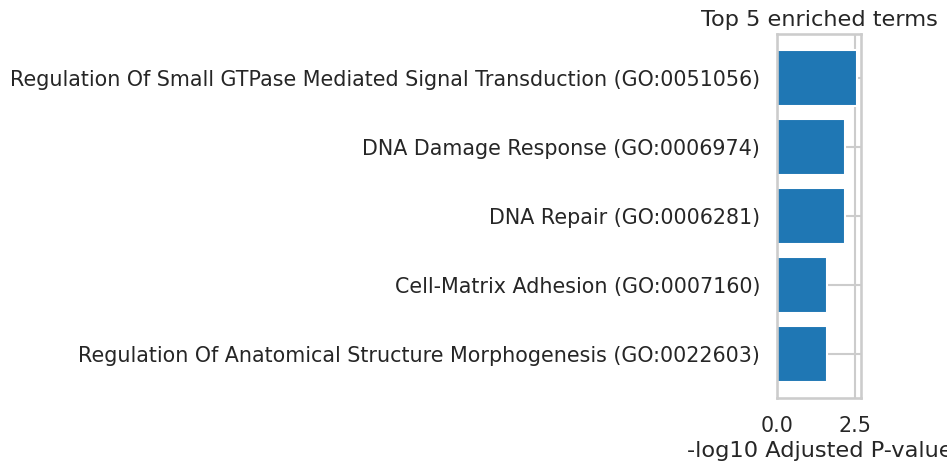

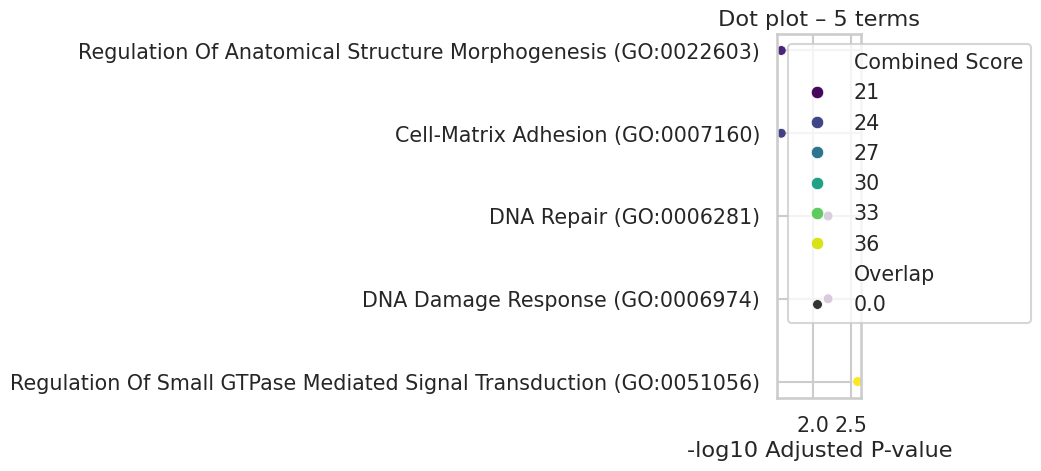

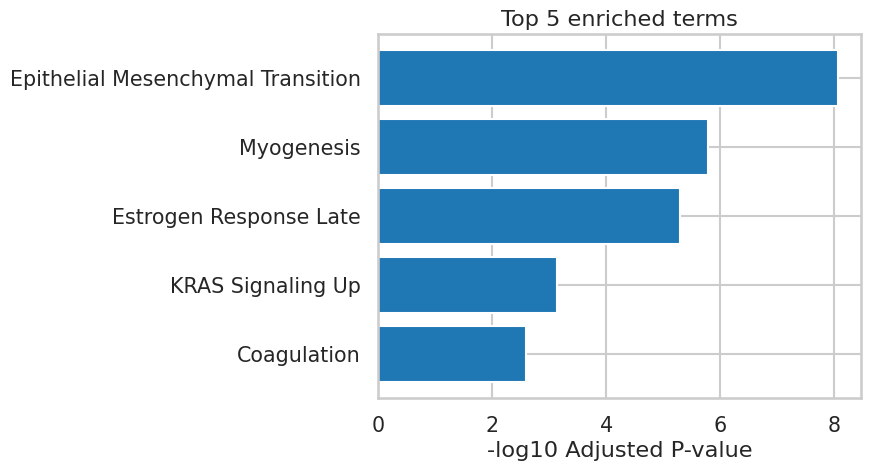

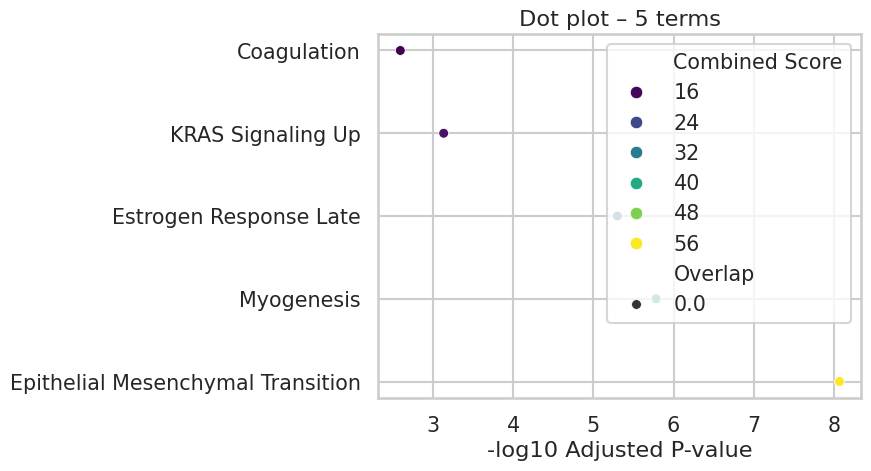

In [14]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

def plot_enrichment(df: pd.DataFrame,
                    p_col: str = "Adjusted P-value",
                    geneset_col: str = "Term",
                    size_col: str = "Overlap",      # or "Genes"
                    color_col: str = "Combined Score",
                    top_n: int = 15,
                    figsize: tuple = (9, 5),
                   fig_name: str = "enrichment"):
    """
    Visualises an enrichment result DataFrame with:
    1. horizontal bar plot  (−log10 p-value)
    2. dot plot             (−log10 p-value × gene-set size × color)
    
    Parameters
    ----------
    df : DataFrame
        The result table from gseapy.enrichr() or gseapy.gsea().
    p_col : str
        Column with (adjusted) p-values.
    geneset_col : str
        Column with gene-set names.
    size_col : str
        Column encoding gene-set size (e.g. "Overlap" or "Genes").
    color_col : str
        Column to colour-map in the dot plot.
    top_n : int
        How many top rows (by p-value) to display.
    figsize : tuple
        Figure size for each plot.
    """
    if df.empty:
        raise ValueError("Enrichment DataFrame is empty.")

    # keep only numeric rows
    df = df.copy()
    df[p_col] = pd.to_numeric(df[p_col], errors="coerce")
    df = df.dropna(subset=[p_col])
    df = df[pd.to_numeric(df[p_col], errors="coerce") < 0.1]
    if df.empty:
        raise ValueError(f"No numeric {p_col} values to plot.")

    df_top = df.sort_values(p_col).head(top_n)
    y_labels = df_top[geneset_col]

    log_p = -np.log10(df_top[p_col].values)

    # ── 1. horizontal bar plot ─────────────────────────────────────
    plt.figure(figsize=figsize)
    plt.barh(y_labels, log_p)
    plt.xlabel(f"-log10 {p_col}")
    plt.title(f"Top {top_n} enriched terms")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    # plt.show()

    save_fig(f"{fig_name}_bar.pdf")
    # ── 2. dot (bubble) plot ───────────────────────────────────────
    # ensure size & colour columns numeric
    df_top[size_col]   = pd.to_numeric(df_top[size_col], errors="coerce").fillna(0)
    df_top[color_col]  = pd.to_numeric(df_top[color_col], errors="coerce").fillna(0)

    plt.figure(figsize=figsize)
    sns.scatterplot(data=df_top,
                    x=log_p,
                    y=y_labels,
                    size=size_col,
                    hue=color_col,
                    palette="viridis",
                    sizes=(50, 600),
                    legend="brief")
    plt.xlabel(f"-log10 {p_col}")
    plt.ylabel("")
    plt.title(f"Dot plot – {top_n} terms")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    # plt.show()
    save_fig(f"{fig_name}_dot.pdf")

# ────────────────────────────────────────────────────────────────
# Usage example   (assuming you already have `enr` from gseapy.enrichr)
plot_enrichment(
    df           = enrGOBP.results,
    p_col        = "Adjusted P-value",
    geneset_col  = "Term",
    size_col     = "Overlap",
    color_col    = "Combined Score",
    top_n        = 5,
    fig_name = "enrGOBP150"
)


# plot_enrichment(
#     df           = enrKEGG.results,
#     p_col        = "Adjusted P-value",
#     geneset_col  = "Term",
#     size_col     = "Overlap",
#     color_col    = "Combined Score",
#     top_n        = 5
# )
plot_enrichment(
    df           = enrHALL.results,
    p_col        = "Adjusted P-value",
    geneset_col  = "Term",
    size_col     = "Overlap",
    color_col    = "Combined Score",
    top_n        = 5,
    fig_name = "enrHall150"
)


/scratch/9913427.1.b/ipykernel_257463/2943530583.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups_order, showfliers=False)


[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/BRCASHAPvals_20250818_104935.pdf


PosixPath('/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/BRCASHAPvals_20250818_104935.pdf')

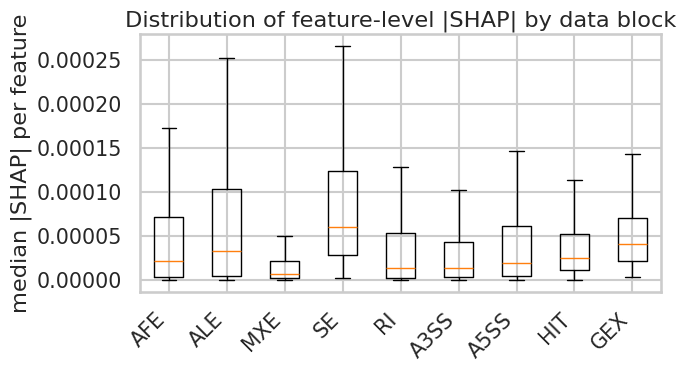

In [15]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

# -------- 1.  Load per-feature |SHAP| values -----------------------------
csv_path = Path(
    "/projectnb2/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/shap/BRCA/shap_mean_abs.csv"
)

# csv_path = Path(
#     "/projectnb2/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_nopretrain/ACC/ACC/shap/ACC/shap_mean_abs.csv"
# )

df_feat = (
    pd.read_csv(csv_path, index_col=0, header=None, names=["abs"])
      .iloc[1:]                     # skip the header row you wrote earlier
)

# 2.  Assign each feature to an info-type block ---------------------------
def label_block(fname: str) -> str:
    # keeps full tag; no truncation
    return fname.split("::", 1)[0]

df_feat["group"] = df_feat.index.map(label_block)

# 3.  Gather lists of |SHAP| per group (for boxplot) ----------------------
groups_order = [
    "AFE","ALE","MXE","SE","RI","A3SS","A5SS","HIT",   # ARP sub-types
    "GEX"#, "CLIN"
]

box_df = (
    df_feat.groupby("group")["abs"]
           .apply(list)
           .to_dict()
)

# Ensure every label exists, even if empty → matplotlib handles empty lists
data = [box_df.get(g, []) for g in groups_order]

# 4.  Plot ---------------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.boxplot(data, labels=groups_order, showfliers=False)
plt.ylabel("median |SHAP| per feature")
plt.title("Distribution of feature-level |SHAP| by data block")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
# plt.show()
save_fig("BRCASHAPvals.pdf")

/scratch/9913427.1.b/ipykernel_257463/1165451481.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=groups_order, showfliers=False)


[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/clinIncludedBRCASHAPvals_20250818_104947.pdf


PosixPath('/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/clinIncludedBRCASHAPvals_20250818_104947.pdf')

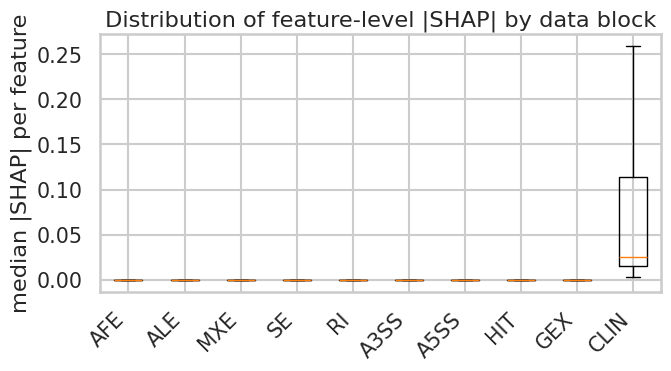

In [16]:
groups_order = [
    "AFE","ALE","MXE","SE","RI","A3SS","A5SS","HIT",   # ARP sub-types
    "GEX", "CLIN"
]

box_df = (
    df_feat.groupby("group")["abs"]
           .apply(list)
           .to_dict()
)

# Ensure every label exists, even if empty → matplotlib handles empty lists
data = [box_df.get(g, []) for g in groups_order]

# 4.  Plot ---------------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.boxplot(data, labels=groups_order, showfliers=False)
plt.ylabel("median |SHAP| per feature")
plt.title("Distribution of feature-level |SHAP| by data block")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
save_fig("clinIncludedBRCASHAPvals.pdf")

[wrote] /projectnb2/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/shap/BRCA/topAFE50_shap_BRCA.csv


/scratch/9913427.1.b/ipykernel_257463/1534997961.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/TopSHAP_BRC A_20250818_105038.pdf


PosixPath('/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/TopSHAP_BRC A_20250818_105038.pdf')

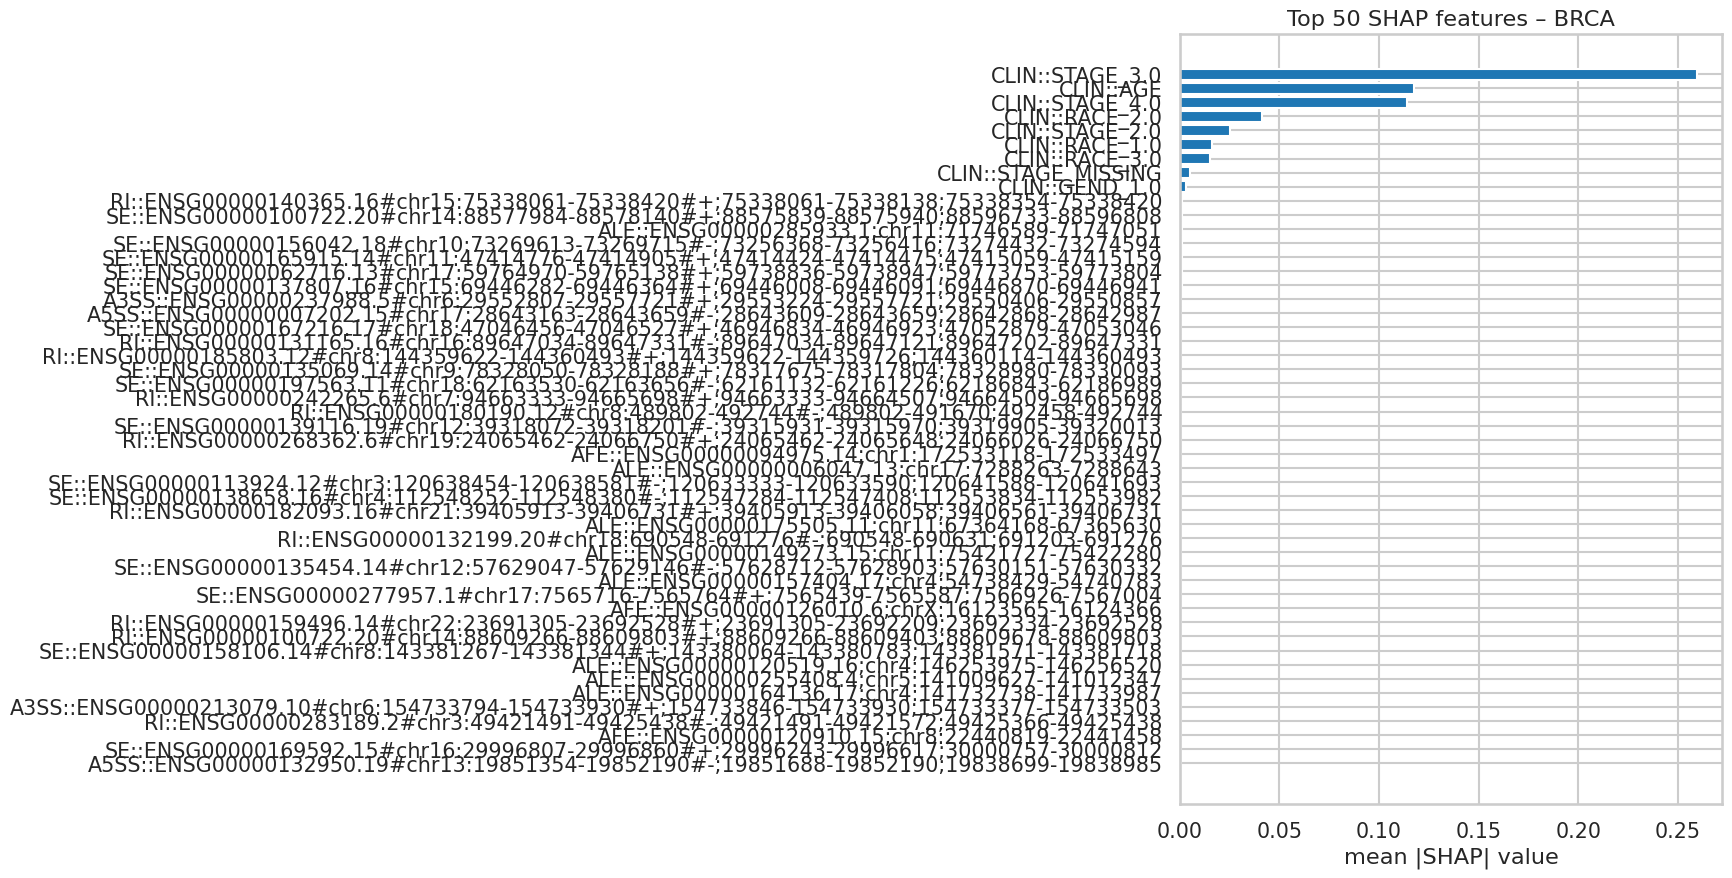

In [18]:
# ------------------------------------------------------------------
# 5.  Extract the most influential features ------------------------
# ------------------------------------------------------------------
TOP_N = 50                                     # change to taste

afe_df = df_feat#.loc[df_feat["group"] == "AFE"]
top_df = (
    afe_df.sort_values("abs", ascending=False)      # rank high→low
          .head(TOP_N)                               # keep N best
          .reset_index()
          .rename(columns={"index": "feature",
                           "abs":    "mean_abs_shap"})
            
    
)

# 6.  Write to disk -----------------------------------------------
out_csv = csv_path.parent / f"topAFE{TOP_N}_shap_BRCA.csv"
top_df.to_csv(out_csv, index=False)
print(f"[wrote] {out_csv}")

# 7.  Optional: bar-plot of top features --------------------------
plt.figure(figsize=(7, TOP_N * 0.18 + 1))      # auto-scale height
plt.barh(top_df["feature"][::-1],              # reverse → rank 1 at top
         top_df["mean_abs_shap"][::-1])
plt.xlabel("mean |SHAP| value")
plt.title(f"Top {TOP_N} SHAP features – BRCA")
plt.tight_layout()

save_fig("TopSHAP_BRC A.pdf")          

[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/ModalityCorrelation/Modality_SHAP_Correlation_20250715_163137.png


PosixPath('/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/ModalityCorrelation/Modality_SHAP_Correlation_20250715_163137.png')

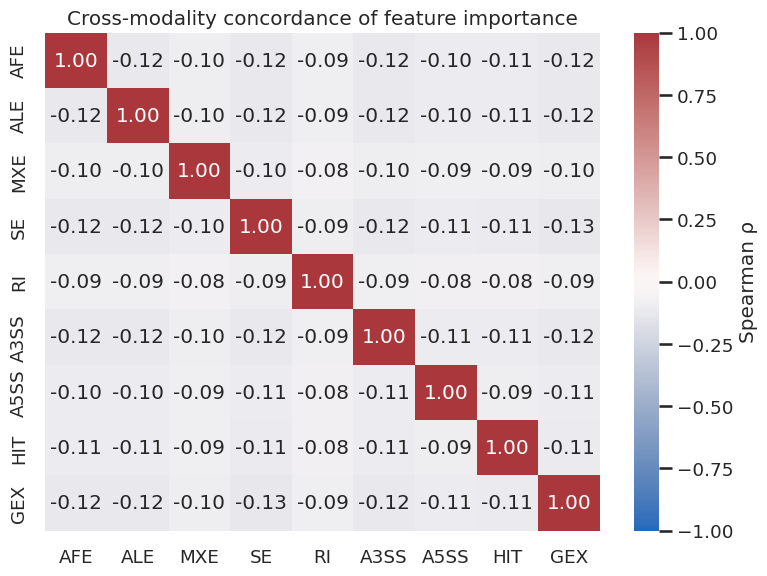

In [70]:
import ast
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
SHAP_ROOT = Path(
    "/projectnb/evolution/zwakefield/tcga/sir_analysis/"
    "survivalModel/mlpCOX/shap"
)
MODALITIES = ["AFE","ALE","MXE","SE","RI","A3SS","A5SS","HIT","GEX"]
FIG_SUBDIR = "ModalityCorrelation"
# ────────────────────────────────────────────────────────────────────

# Gather every <CANCER>/<MODALITY>/shap_mean_abs.csv two levels deep
mod_lists = {m: [] for m in MODALITIES}

for csv in SHAP_ROOT.glob("*/*/shap_mean_abs.csv"):
    cancer, modality = csv.parts[-3:-1]           # e.g. LUAD, AFE
    if modality not in MODALITIES:
        continue

    df = (
        pd.read_csv(csv, index_col=0, header=None, names=["abs"])
          .iloc[1:]                               # drop header row
    )
    # tag feature with cancer so duplicates keep both entries
    df.index = [f"{idx}::{cancer}" for idx in df.index]
    mod_lists[modality].append(df["abs"])

# Concatenate to one Series per modality
mod_series = {
    m: pd.concat(lst) if lst else pd.Series(dtype=float)
    for m, lst in mod_lists.items()
}

# Ensure we have data
if not any(len(s) for s in mod_series.values()):
    raise RuntimeError("No SHAP files found – check SHAP_ROOT path.")

# Align into a DataFrame (feature rows × modality cols)
all_idx = pd.Index(sorted(set().union(*(s.index for s in mod_series.values()))))
X = pd.DataFrame({m: s.reindex(all_idx, fill_value=0) for m, s in mod_series.items()})

# Spearman ρ correlation matrix
corr = X.corr(method="spearman")

# ─────────────────────────── plot ────────────────────────────────
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1,
            cmap="vlag", cbar_kws={"label": "Spearman ρ"})
plt.title("Cross-modality concordance of feature importance")
plt.tight_layout()

save_fig("Modality_SHAP_Correlation", subdir=FIG_SUBDIR)

[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/JaccardOverlap/Jaccard_Top25_Genes_20250818_105223.png
[done] → see plots/JaccardOverlap/


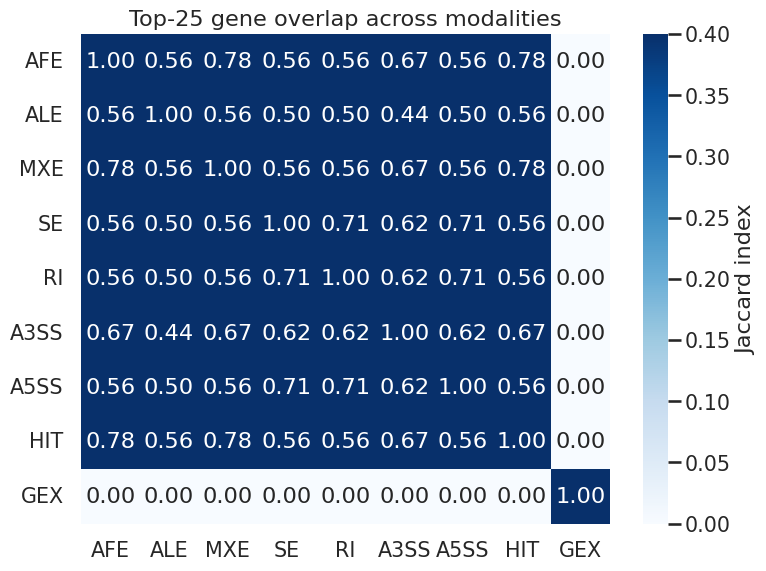

In [19]:
import itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ─────────────── settings ──────────────────────────────────────
SHAP_ROOT = Path(
    "/projectnb/evolution/zwakefield/tcga/sir_analysis/"
    "survivalModel/mlpCOX/shap"
)
MODS   = ["AFE","ALE","MXE","SE","RI","A3SS","A5SS","HIT","GEX"]
TOP_K  = 25
FIGDIR = "JaccardOverlap"
# ───────────────────────────────────────────────────────────────

# 1 · collect sets of top-25 genes (collapse across cancers)
gene_sets = {m: set() for m in MODS}
for csv in SHAP_ROOT.glob("*/*/shap_mean_abs.csv"):
    _, mod = csv.parts[-3:-1]
    if mod not in MODS:
        continue
    df = (pd.read_csv(csv, index_col=0, header=None, names=["abs"])
            .iloc[1:]
            .sort_values("abs", ascending=False)
            .head(TOP_K))
    genes = {idx.split("::")[0] for idx in df.index}
    gene_sets[mod].update(genes)

gene_sets = {m: s for m, s in gene_sets.items() if s}

# 2 · Jaccard matrix
jac = pd.DataFrame(index=MODS, columns=MODS, dtype=float)
for i, j in itertools.product(MODS, repeat=2):
    if i not in gene_sets or j not in gene_sets:
        jac.loc[i, j] = np.nan
        continue
    inter = len(gene_sets[i] & gene_sets[j])
    union = len(gene_sets[i] | gene_sets[j])
    jac.loc[i, j] = inter / union if union else np.nan

# 3 · heat-map
plt.figure(figsize=(8, 6))
sns.heatmap(jac, annot=True, fmt=".2f", vmin=0, vmax=0.4,
            cmap="Blues", cbar_kws={"label": "Jaccard index"})
plt.title("Top-25 gene overlap across modalities")
plt.tight_layout()

save_fig("Jaccard_Top25_Genes", subdir=FIGDIR)   # vector PDF
print("[done] → see plots/JaccardOverlap/")

[wrote] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/EnsembleComparison/ensemble_vs_mlpCox.csv


/scratch/9913427.1.b/ipykernel_257463/2434274825.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cmp, x="cancer", y="delta", palette="vlag")


[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/EnsembleComparison/Delta_Bar_Ensemble_vs_mlpCox_20250818_105238.pdf
[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/EnsembleComparison/Scatter_Ensemble_vs_mlpCox_20250818_105238.pdf
[done]


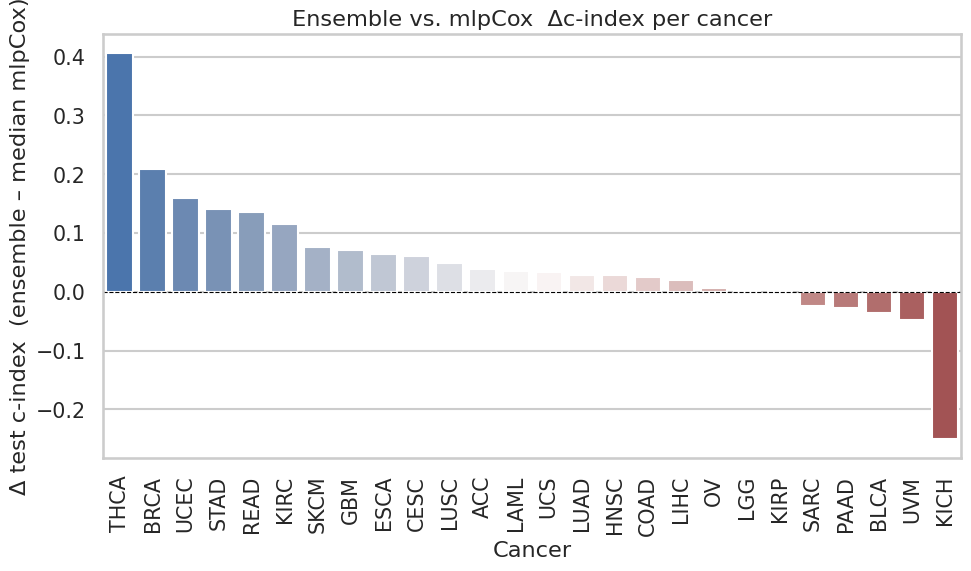

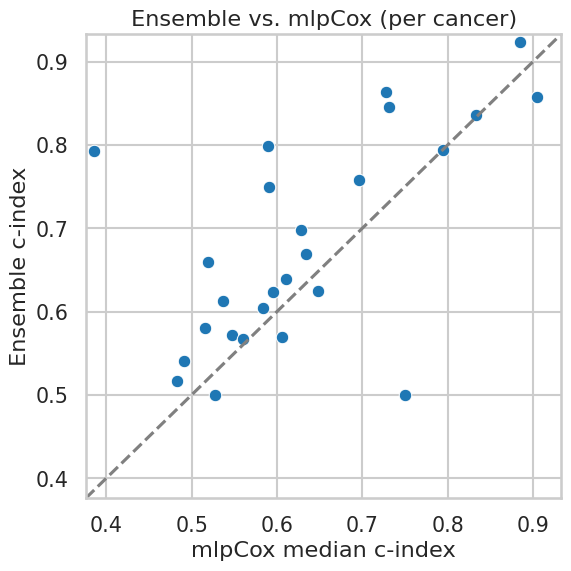

In [20]:
import json          # ← ADD THIS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

ROOT_MLP = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/models")
ROOT_ENS = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/models")
OUT_SUB  = "EnsembleComparison"                    # plots/<OUT_SUB>/

# ────────────────────────────── mlpCox metrics ──────────────────────────────
rows_mlp = []
for mpath in ROOT_MLP.glob("*/*/metrics.json"):    # <CANCER>/<MODALITY>/metrics.json
    cancer   = mpath.parts[-3]                     # e.g. BLCA
    modality = mpath.parts[-2]                     # e.g. A5SS
    try:
        with open(mpath) as fh:
            meta = json.load(fh)
        cidx = (meta.get("test_cidx") or meta.get("c_index") or
                meta.get("cindex")   or meta.get("concordance_index"))
    except Exception as err:
        print(f"[skip] {mpath} – {err}")
        continue
    if cidx is None:
        print(f"[warn] {mpath}: no c-index key")
        continue
    rows_mlp.append({"cancer": cancer, "modality": modality, "cidx": cidx})

df_mlp = pd.DataFrame(rows_mlp)
if df_mlp.empty:
    raise RuntimeError("No mlpCox metrics found.")

mlp_median = (
    df_mlp.groupby("cancer")["cidx"]
          .median()
          .rename("mlp_median")
          .reset_index()
)

# ──────────────────────────── ensemble metrics ──────────────────────────────
rows_ens = []
for mpath in ROOT_ENS.glob("*/metrics.json"):      # <CANCER>/metrics.json
    cancer = mpath.parts[-2]
    try:
        with open(mpath) as fh:
            meta = json.load(fh)
        cidx = (meta.get("test_C") or meta.get("c_index") or
                meta.get("cindex")   or meta.get("concordance_index"))
    except Exception as err:
        print(f"[skip] {mpath} – {err}")
        continue
    if cidx is None:
        print(f"[warn] {mpath}: no c-index key")
        continue
    rows_ens.append({"cancer": cancer, "ensemble_cidx": cidx})

df_ens = pd.DataFrame(rows_ens)
if df_ens.empty:
    raise RuntimeError("No ensemble metrics found.")

# ─────────────────────── merge & Δ computation ──────────────────────────────
df_cmp = (
    pd.merge(mlp_median, df_ens, on="cancer", how="inner")
      .assign(delta=lambda d: d["ensemble_cidx"] - d["mlp_median"])
      .sort_values("delta", ascending=False)
)

if df_cmp.empty:
    raise RuntimeError("No overlapping cancers between pipelines.")

# ─────────────────────────────── outputs ────────────────────────────────────
out_dir = ROOT_MLP.parent / "plots" / OUT_SUB    # …/mlpCOX/plots/…
out_dir.mkdir(parents=True, exist_ok=True)

df_cmp.to_csv(out_dir / "ensemble_vs_mlpCox.csv", index=False)
print(f"[wrote] {out_dir/'ensemble_vs_mlpCox.csv'}")

# ―― bar plot Δ ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――
plt.figure(figsize=(10, 6))
sns.barplot(data=df_cmp, x="cancer", y="delta", palette="vlag")
plt.axhline(0, ls="--", lw=0.8, c="black")
plt.ylabel("Δ test c-index  (ensemble – median mlpCox)")
plt.xlabel("Cancer")
plt.title("Ensemble vs. mlpCox  Δc-index per cancer")
plt.xticks(rotation=90, ha="center")
plt.tight_layout()
save_fig("Delta_Bar_Ensemble_vs_mlpCox.pdf", subdir=OUT_SUB)

# ―― scatter plot ―――――――――――――――――――――――――――――――――――――――――――――――――――――
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_cmp, x="mlp_median", y="ensemble_cidx")
lims = [df_cmp[["mlp_median", "ensemble_cidx"]].min().min() - 0.01,
        df_cmp[["mlp_median", "ensemble_cidx"]].max().max() + 0.01]
plt.plot(lims, lims, ls="--", c="grey")          # y = x diagonal
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("mlpCox median c-index")
plt.ylabel("Ensemble c-index")
plt.title("Ensemble vs. mlpCox (per cancer)")
plt.tight_layout()
save_fig("Scatter_Ensemble_vs_mlpCox.pdf", subdir=OUT_SUB)

print("[done]")

[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/Top10FeatureHeatmap/Top10_SHAP_Heatmap_20250818_105340.pdf


PosixPath('/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/Top10FeatureHeatmap/Top10_SHAP_Heatmap_20250818_105340.pdf')

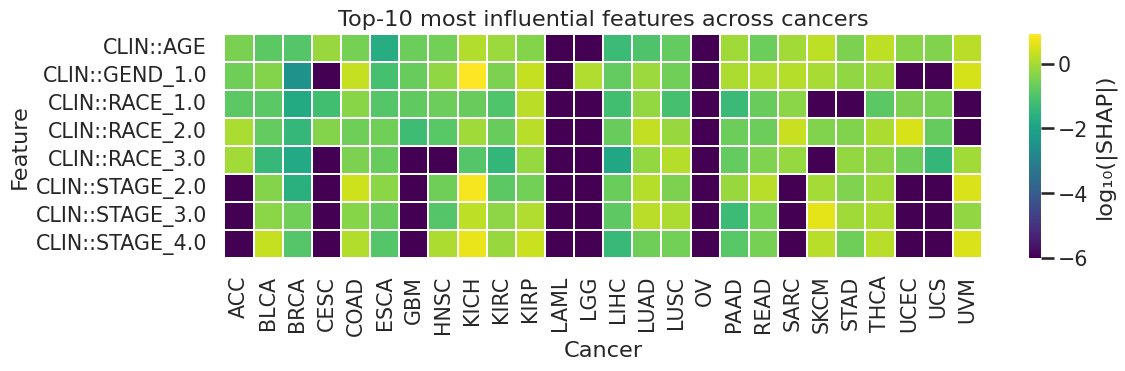

In [21]:
import ast
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────── paths ────────────────────────────
SHAP_ROOT = Path("/projectnb2/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/shap")
# pattern: <ROOT>/<CANCER>/shap_mean_abs.csv   (adjust if moved)

FIG_SUBDIR = "Top10FeatureHeatmap"       # …/plots/<FIG_SUBDIR>/

# ─────────────────────── gather top-10 per cancer ───────────────
records = []
for csv in SHAP_ROOT.glob("*/shap_mean_abs.csv"):
    cancer = csv.parent.name             # directory = cancer code
    df = (
        pd.read_csv(csv, index_col=0, header=None, names=["abs"])
          .iloc[1:]                      # drop placeholder header
          .sort_values("abs", ascending=False)
          .head(10)                      # TOP-10
    )
    for feat, row in df.itertuples():
        records.append({"feature": feat, "cancer": cancer, "abs": row})

all_df = pd.DataFrame(records)
if all_df.empty:
    raise RuntimeError("No SHAP files found—check SHAP_ROOT path.")

# pivot → feature rows × cancer cols
heat_df = (
    all_df.pivot_table(index="feature", columns="cancer",
                       values="abs", fill_value=0)
          .sort_index(axis=1)            # alphabetical cancer order
)

# optional: keep only features that appeared in ≥2 cancers
heat_df = heat_df[heat_df.gt(0).sum(axis=1) >= 3]

# ───────────────────────────── plot ─────────────────────────────
plt.figure(figsize=(0.35 * heat_df.shape[1] + 3,
                    0.25 * heat_df.shape[0] + 2))     # auto-scale
sns.heatmap(np.log10(heat_df + 1e-6),                 # compress dynamic range
            cmap="viridis", linewidths=.3,
            cbar_kws={"label": "log₁₀(|SHAP|)"})

plt.title("Top-10 most influential features across cancers")
plt.ylabel("Feature")
plt.xlabel("Cancer")
plt.tight_layout()
save_fig("Top10_SHAP_Heatmap.pdf", subdir=FIG_SUBDIR)     # → PDF by default


/scratch/9913427.1.b/ipykernel_257463/1491777658.py:67: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/Top10FeatureHeatmap/Top10_SHAP_Heatmap_NonClinical_20250818_105347.pdf


PosixPath('/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/Top10FeatureHeatmap/Top10_SHAP_Heatmap_NonClinical_20250818_105347.pdf')

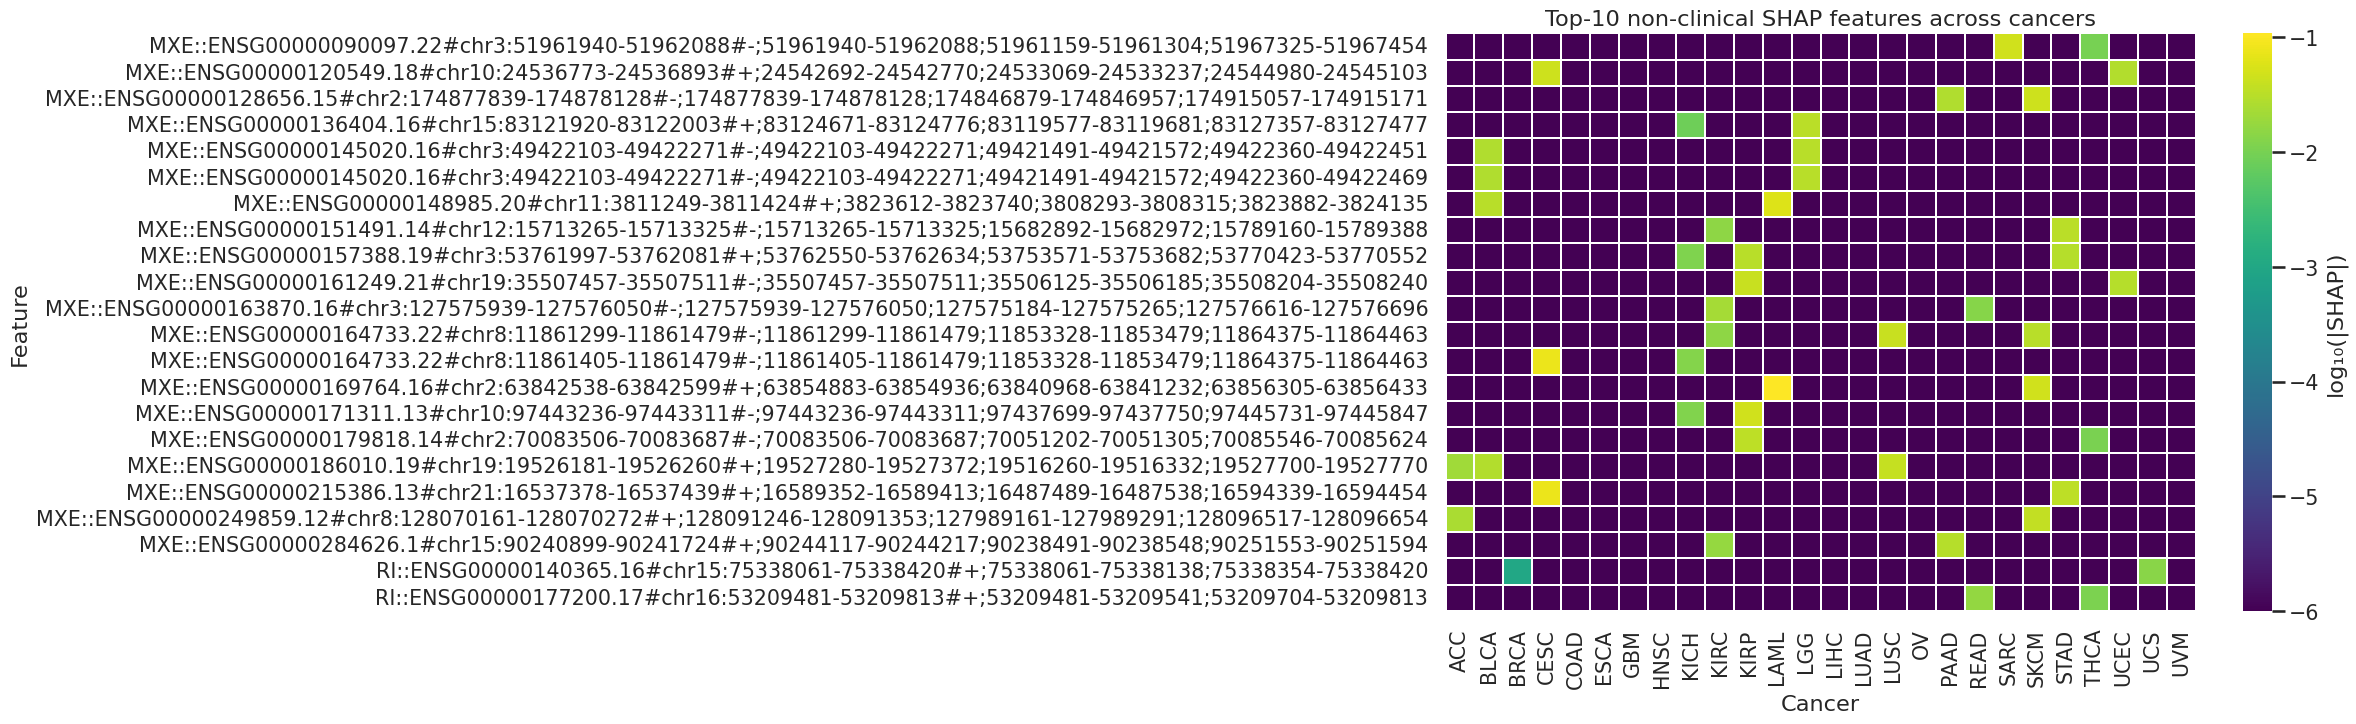

In [22]:
SHAP_ROOT  = Path(
    "/projectnb2/evolution/zwakefield/tcga/sir_analysis/"
    "survivalModel/ensemble/shap"
)  # pattern: <SHAP_ROOT>/<CANCER>/shap_mean_abs.csv

FIG_SUBDIR = "Top10FeatureHeatmap"       # plots/<FIG_SUBDIR>/…

# ───────────────────── helper: exclude clinical features ────────
def is_non_clinical(feature_name: str) -> bool:
    """
    Returns True for any feature NOT belonging to the clinical block.
    Assumes clinical features start with 'CLIN::'.
    """
    return not feature_name.startswith("CLIN::")

# ───────────────────── gather top-10 per cancer ─────────────────
records = []
for csv in SHAP_ROOT.glob("*/shap_mean_abs.csv"):
    cancer = csv.parent.name                         # directory = cancer code
    df = (
        pd.read_csv(csv, index_col=0, header=None, names=["abs"])
          .iloc[1:]                                  # drop header row
          .loc[lambda d: d.index.map(is_non_clinical)]  # ← exclude CLIN
          .sort_values("abs", ascending=False)
          .head(10)                                  # TOP-10 non-clinical
    )
    for feat, abs_val in df.itertuples():
        records.append({"feature": feat,
                        "cancer":  cancer,
                        "abs":     abs_val})

all_df = pd.DataFrame(records)
if all_df.empty:
    raise RuntimeError(
        "No non-clinical SHAP features found. "
        "Check SHAP_ROOT path or feature prefixes."
    )

# ───────────────────── pivot → feature × cancer ─────────────────
heat_df = (
    all_df.pivot_table(index="feature",
                       columns="cancer",
                       values="abs",
                       fill_value=0)
          .sort_index(axis=1)             # alphabetic cancer order
)

# Optionally: keep only features present in ≥2 cancers
heat_df = heat_df[heat_df.gt(0).sum(axis=1) >= 2]

# ───────────────────── plot heat-map ────────────────────────────
plt.figure(
    figsize=(0.35 * heat_df.shape[1] + 3,
             0.25 * heat_df.shape[0] + 2)
)  # auto-scale figure

sns.heatmap(
    np.log10(heat_df + 1e-6),            # compress dynamic range
    cmap="viridis",
    linewidths=.3,
    cbar_kws={"label": "log₁₀(|SHAP|)"},
)

plt.title("Top-10 non-clinical SHAP features across cancers")
plt.ylabel("Feature")
plt.xlabel("Cancer")
plt.tight_layout()

# Vector PDF (default) → …/plots/Top10FeatureHeatmap/…
save_fig("Top10_SHAP_Heatmap_NonClinical.pdf", subdir=FIG_SUBDIR)

/scratch/9913427.1.b/ipykernel_257463/2481889359.py:75: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/Top10FeatureHeatmap/Top10_SHAP_Heatmap_NonClinical_20250818_105400.pdf


PosixPath('/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/Top10FeatureHeatmap/Top10_SHAP_Heatmap_NonClinical_20250818_105400.pdf')

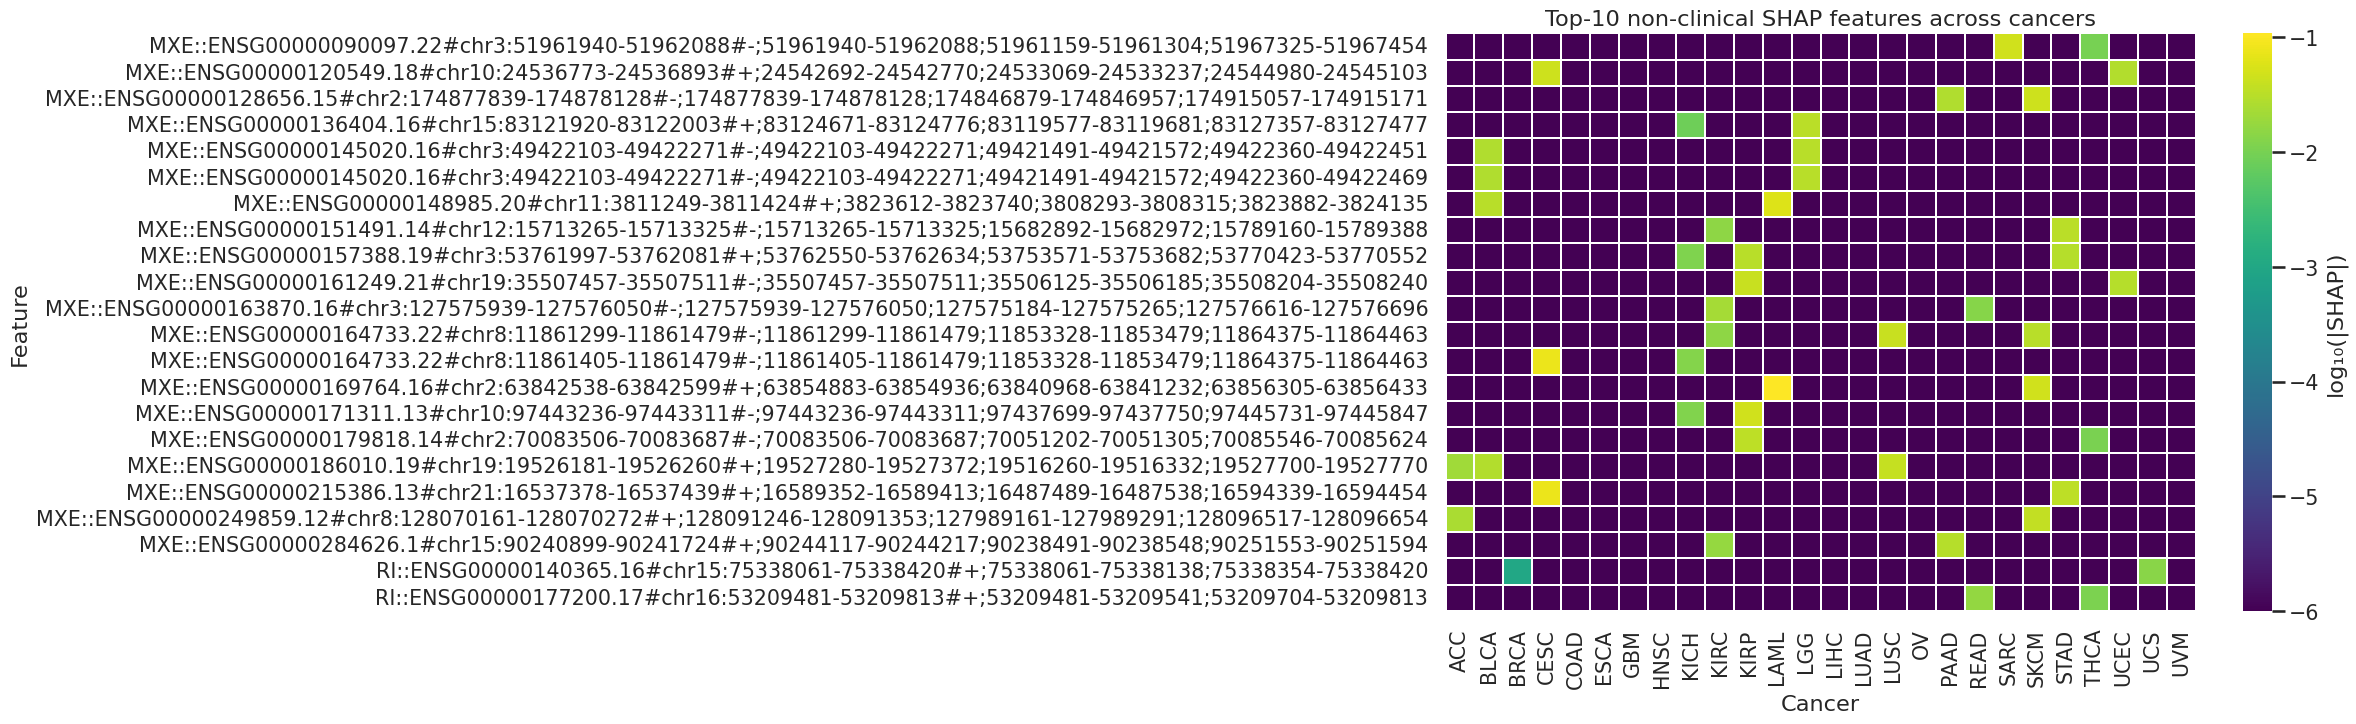

In [23]:
SHAP_ROOT  = Path(
    "/projectnb2/evolution/zwakefield/tcga/sir_analysis/"
    "survivalModel/ensemble/shap"
)  # pattern: <SHAP_ROOT>/<CANCER>/shap_mean_abs.csv

FIG_SUBDIR = "Top10FeatureHeatmap"       # plots/<FIG_SUBDIR>/…

# ───────────────────── helper: exclude clinical features ────────
def is_non_clinical(feature_name: str) -> bool:
    """
    Returns True for any feature NOT belonging to the clinical block.
    Assumes clinical features start with 'CLIN::'.
    """
    return not feature_name.startswith("CLIN::")

def is_types(feature_name: str,
            category: str) -> bool:
    """
    Returns True for any feature NOT belonging to the clinical block.
    Assumes clinical features start with 'CLIN::'.
    """
    return not feature_name.startswith(f"{category}::")

# ───────────────────── gather top-10 per cancer ─────────────────
records = []
for csv in SHAP_ROOT.glob("*/shap_mean_abs.csv"):
    cancer = csv.parent.name                         # directory = cancer code
    df = (
        pd.read_csv(csv, index_col=0, header=None, names=["abs"])
          .iloc[1:]                                  # drop header row
          .loc[lambda d: d.index.map(is_non_clinical)]  # ← exclude CLIN
          .sort_values("abs", ascending=False)
          .head(10)                                  # TOP-10 non-clinical
    )
    for feat, abs_val in df.itertuples():
        records.append({"feature": feat,
                        "cancer":  cancer,
                        "abs":     abs_val})

all_df = pd.DataFrame(records)
if all_df.empty:
    raise RuntimeError(
        "No non-clinical SHAP features found. "
        "Check SHAP_ROOT path or feature prefixes."
    )

# ───────────────────── pivot → feature × cancer ─────────────────
heat_df = (
    all_df.pivot_table(index="feature",
                       columns="cancer",
                       values="abs",
                       fill_value=0)
          .sort_index(axis=1)             # alphabetic cancer order
)

# Optionally: keep only features present in ≥2 cancers
heat_df = heat_df[heat_df.gt(0).sum(axis=1) >= 2]

# ───────────────────── plot heat-map ────────────────────────────
plt.figure(
    figsize=(0.35 * heat_df.shape[1] + 3,
             0.25 * heat_df.shape[0] + 2)
)  # auto-scale figure

sns.heatmap(
    np.log10(heat_df + 1e-6),            # compress dynamic range
    cmap="viridis",
    linewidths=.3,
    cbar_kws={"label": "log₁₀(|SHAP|)"},
)

plt.title("Top-10 non-clinical SHAP features across cancers")
plt.ylabel("Feature")
plt.xlabel("Cancer")
plt.tight_layout()

# Vector PDF (default) → …/plots/Top10FeatureHeatmap/…
save_fig("Top10_SHAP_Heatmap_NonClinical.pdf", subdir=FIG_SUBDIR)

TypeError: FigureCanvasAgg.print_png() got an unexpected keyword argument 'fig'

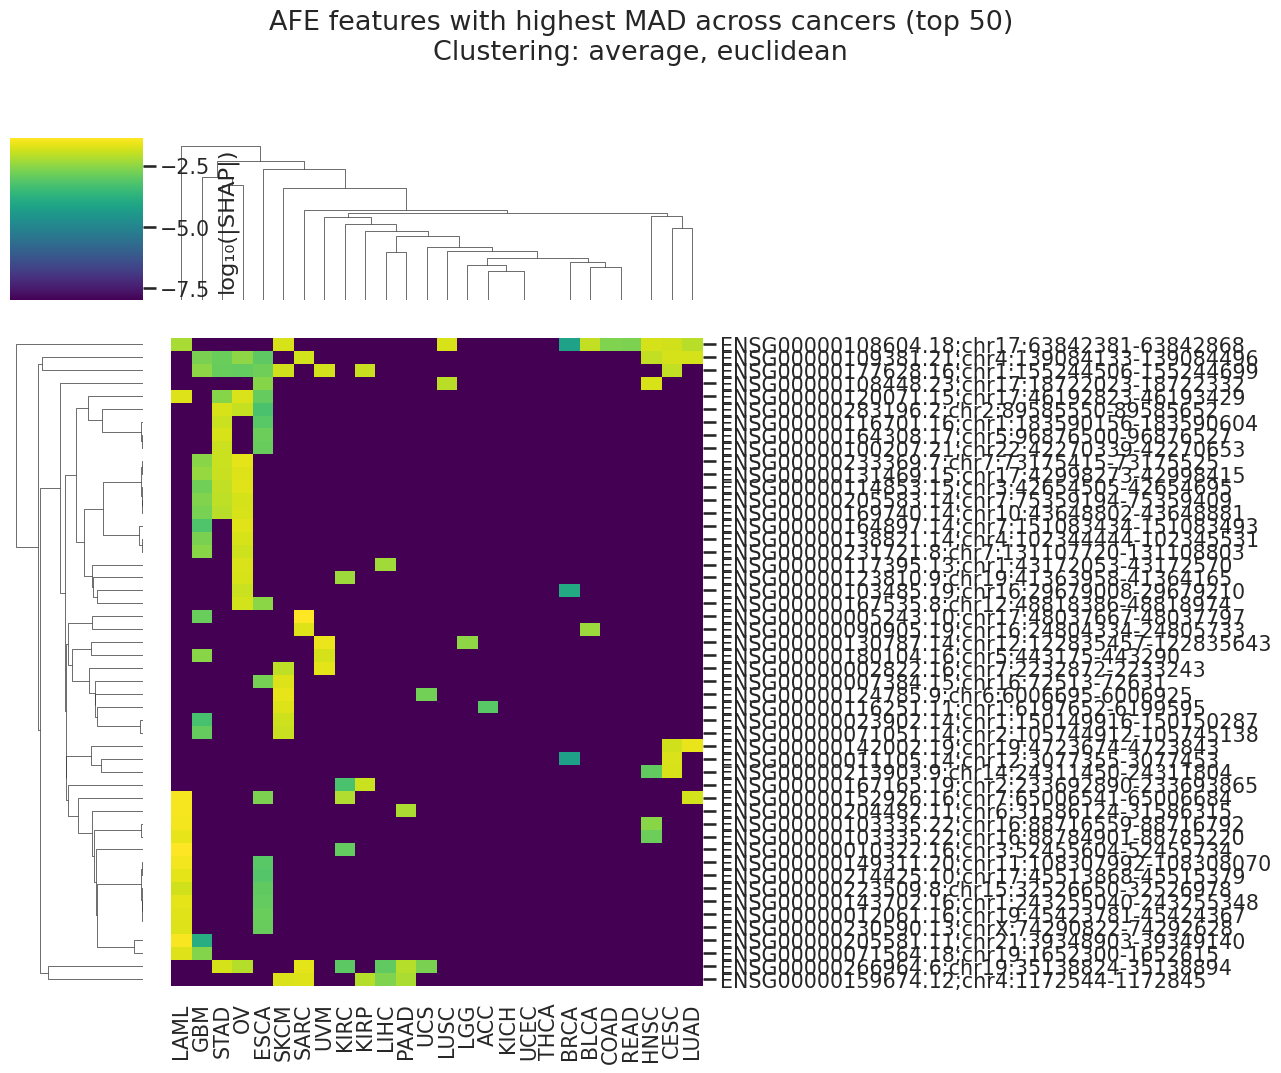

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import median_abs_deviation

# ────────────────── user knobs ──────────────────────────────────
SHAP_ROOT = Path(
    "/projectnb/evolution/zwakefield/tcga/sir_analysis/"
    "survivalModel/ensemble/shap"
)
CATEGORY   = "AFE"          # swap for ALE / MXE / GEX / …
TOP_VAR    = 50             # keep this many highest-MAD features
METRIC     = "euclidean"    # distance metric for linkage
METHOD     = "average"      # linkage method: ward / complete / …
FIG_SUBDIR = "MAD_Clustermaps"
# ────────────────────────────────────────────────────────────────

def in_block(idx: str, block: str) -> bool:
    """True if feature belongs to requested block (AFE::…)."""
    return idx.startswith(f"{block}::")

# 1 ── Build feature × cancer matrix
ser_per_cancer = {}
for csv in SHAP_ROOT.glob("*/shap_mean_abs.csv"):
    cancer = csv.parent.name
    df = (pd.read_csv(csv, index_col=0, header=None, names=["abs"])
            .iloc[1:])
    block_ser = df.loc[[i for i in df.index if in_block(i, CATEGORY)], "abs"]
    if block_ser.empty:
        continue
    block_ser.index = block_ser.index.str.split("::").str[1]   # drop prefix
    ser_per_cancer[cancer] = block_ser

if not ser_per_cancer:
    raise RuntimeError(f"No {CATEGORY} features found under {SHAP_ROOT}")

mat = pd.DataFrame(ser_per_cancer).astype(float)   # NaN where missing

# 2 ── Select most variable rows by MAD across cancers
mad = mat.apply(lambda r: median_abs_deviation(r, nan_policy="omit"), axis=1)
top_feats = mad.sort_values(ascending=False).head(TOP_VAR).index
submat = mat.loc[top_feats]

# 3 ── Fill NaNs with 0 and log-transform
submat_filled = submat.fillna(0)
log_mat = np.log10(submat_filled + 1e-8)

# 4 ── Hierarchical cluster-map
cg = sns.clustermap(
        log_mat,
        figsize=(0.35 * log_mat.shape[1] + 4,
                 # 0.40 * TOP_VAR + 3),
                 0.40 * 20 + 3),
        cmap="viridis",
        metric=METRIC,
        method=METHOD,
        linewidths=0,
        cbar_kws={"label": "log₁₀(|SHAP|)"},
        xticklabels=True,
        yticklabels=True
)

cg.fig.suptitle(
    f"{CATEGORY} features with highest MAD across cancers "
    f"(top {TOP_VAR})\nClustering: {METHOD}, {METRIC}"
)
cg.fig.tight_layout(rect=[0, 0, 1, 0.96])

# 5 ── Save vector PDF
save_fig(f"{CATEGORY}_MADtop{TOP_VAR}_Clustermap",
         fig=cg.fig, subdir=FIG_SUBDIR)

print("[done]  → PDF saved in plots/MAD_Clustermaps/")

/scratch/9913427.1.b/ipykernel_257463/998651519.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/CancerSpecific_Features/AFE_ACC_SpecificTop10_20250818_105429.png
[done]  CSVs (and optional PDF for ACC) → /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/plots/CancerSpecific_Features


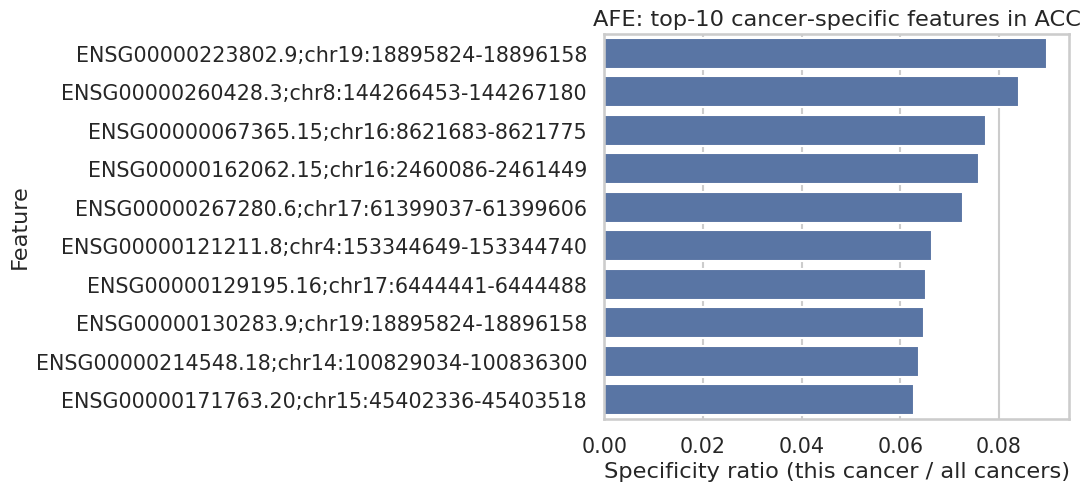

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ───────────────────── user settings ────────────────────────────
SHAP_ROOT = Path(
    "/projectnb/evolution/zwakefield/tcga/sir_analysis/"
    "survivalModel/ensemble/shap"                 # <CANCER>/shap_mean_abs.csv
)
CATEGORY   = "AFE"      # set to ALE / MXE / GEX / …
TOP_K      = 10         # keep N most‑specific features per cancer
PLOT_ONE   = "ACC"     # set to None to skip plotting
FIG_SUBDIR = "CancerSpecific_Features"
SPEC_SHAP  = 0.02      # ignore features whose max |SHAP| < threshold
# ────────────────────────────────────────────────────────────────

def build_matrix(root: Path, block: str) -> pd.DataFrame:
    """Return DataFrame[feature × cancer] of |SHAP|."""
    cols = {}
    for csv in root.glob("*/shap_mean_abs.csv"):
        cancer = csv.parent.name
        df = pd.read_csv(csv, index_col=0, header=None, names=["abs"]).iloc[1:]
        sub = df.loc[df.index.str.startswith(f"{block}::"), "abs"]
        if sub.empty:
            continue
        sub.index = sub.index.str.split("::").str[1]   # strip block prefix
        cols[cancer] = sub
    return pd.DataFrame(cols).fillna(0).astype(float)

# 1 ▸ build matrix
mat = build_matrix(SHAP_ROOT, CATEGORY)
if mat.empty:
    raise RuntimeError(f"No {CATEGORY} features found under {SHAP_ROOT}")

# 2 ▸ per‑feature total & specificity ratios
totals = mat.sum(axis=1) + 1e-8
ratio  = mat.div(totals, axis=0)

# 3 ▸ output directory
out_dir = SHAP_ROOT.parent.parent / "plots" / FIG_SUBDIR
out_dir.mkdir(parents=True, exist_ok=True)

# 4 ▸ iterate over cancers
for cancer in mat.columns:
    # skip tiny features early
    col = ratio[cancer]
    mask = (mat.max(axis=1) >= SPEC_SHAP)
    top_idx = col[mask].nlargest(TOP_K).index

    top = pd.DataFrame({
        "specificity": col.loc[top_idx],
        "abs_shap"   : mat.loc[top_idx, cancer]
    }).sort_values("specificity", ascending=False)

    # CSV per cancer
    top.to_csv(out_dir / f"{CATEGORY}_{cancer}_top{TOP_K}.csv")

    # optional bar‑plot
    if PLOT_ONE and cancer == PLOT_ONE:
        plt.figure(figsize=(6, TOP_K * 0.4 + 1))
        sns.barplot(data=top.reset_index(),
                    y="index", x="specificity",
                    color="#4C72B0")
        plt.xlabel("Specificity ratio (this cancer / all cancers)")
        plt.ylabel("Feature")
        plt.title(f"{CATEGORY}: top-{TOP_K} cancer‑specific features in {cancer}")
        plt.tight_layout()
        save_fig(f"{CATEGORY}_{cancer}_SpecificTop{TOP_K}", subdir=FIG_SUBDIR)

print(f"[done]  CSVs (and optional PDF for {PLOT_ONE}) → {out_dir}")

TypeError: FigureCanvasAgg.print_png() got an unexpected keyword argument 'fig'

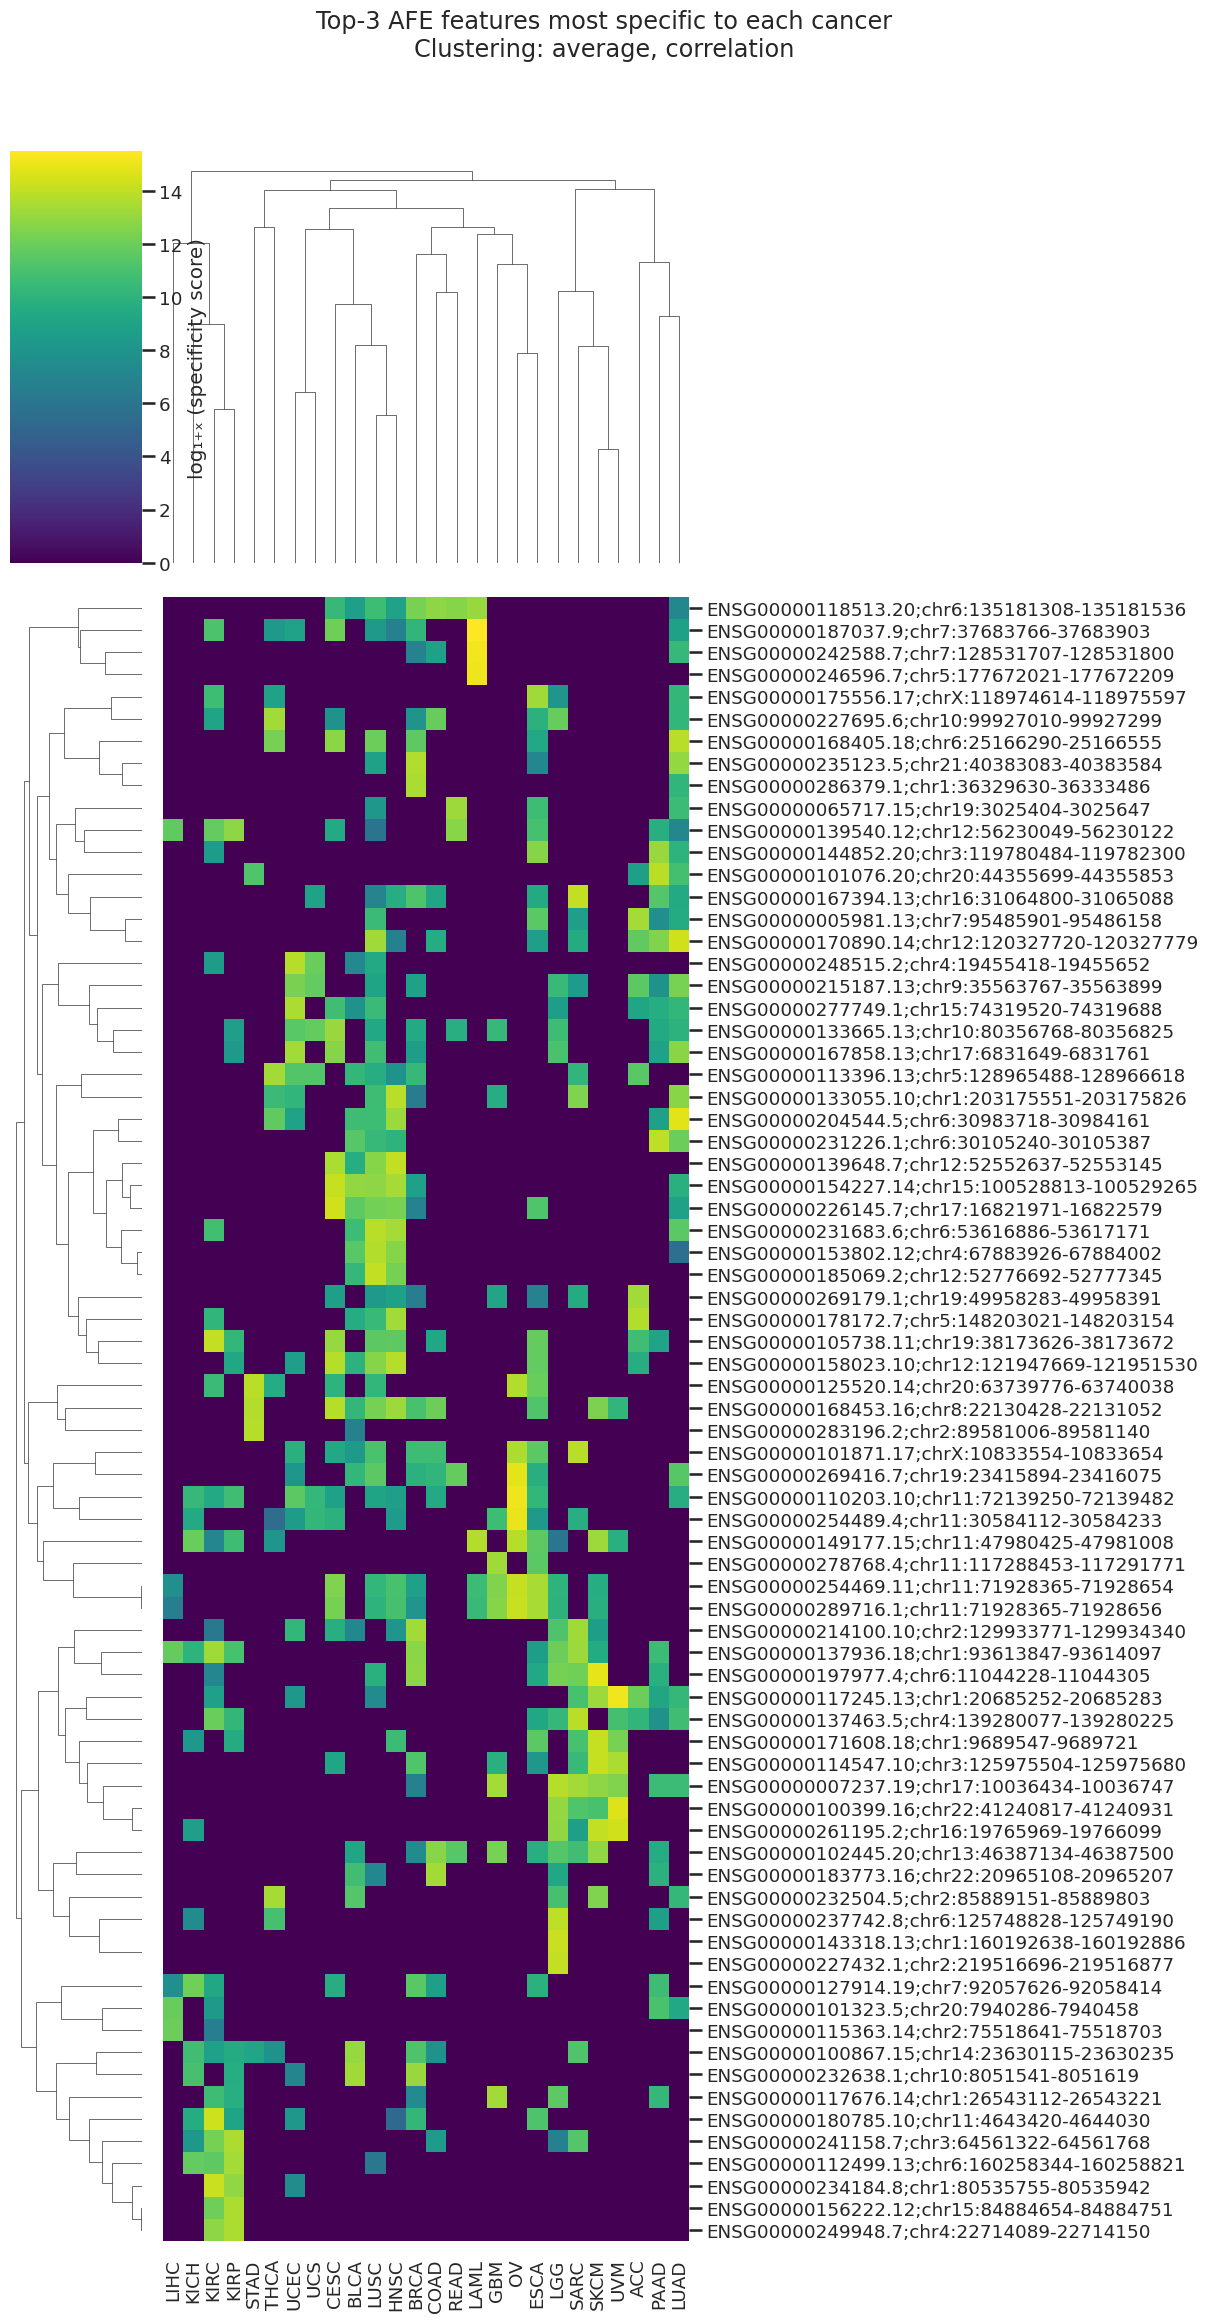

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import median_abs_deviation

# ───────────── user parameters ──────────────────────────────────
SHAP_ROOT = Path(
    "/projectnb/evolution/zwakefield/tcga/sir_analysis/"
    "survivalModel/ensemble/shap"          # <CANCER>/shap_mean_abs.csv
)
CATEGORY   = "AFE"        # AFE, MXE, GEX, …  (use None to include *all*)
TOP_K      = 3           # keep N most specific features per cancer
METRIC     = "correlation"
METHOD     = "average"
FIG_SUBDIR = "CancerSpecificHeat"
# ────────────────────────────────────────────────────────────────

def in_block(idx: str, block: str | None) -> bool:
    if block is None:
        return True
    return idx.startswith(f"{block}::")

# 1.  Build feature × cancer matrix of |SHAP|
series_by_cancer = {}
for csv in SHAP_ROOT.glob("*/shap_mean_abs.csv"):
    cancer = csv.parent.name
    df = (pd.read_csv(csv, index_col=0, header=None, names=["abs"])
            .iloc[1:])

    df_block = df.loc[[i for i in df.index if in_block(i, CATEGORY)], "abs"]
    if df_block.empty:
        continue
    # strip prefix (e.g. AFE::) for readability
    df_block.index = df_block.index.str.split("::").str[-1]
    series_by_cancer[cancer] = df_block.astype(float)

if not series_by_cancer:
    raise RuntimeError("No SHAP data – check SHAP_ROOT or CATEGORY")

mat = pd.DataFrame(series_by_cancer)           # shape: features × cancers

# 2.  Per-feature median & MAD across cancers
med = mat.median(axis=1, skipna=True)
mad = mat.apply(lambda r: median_abs_deviation(r, nan_policy="omit"), axis=1)

# 3.  Specificity score (clip negatives → 0)
spec = ((mat.sub(med, axis=0)).div(mad + 1e-8, axis=0)).clip(lower=0)

# 4.  Keep the top-K specific features *per cancer*
keep_feats = set()
for c in spec.columns:
    top_f = spec[c].nlargest(TOP_K).index
    keep_feats.update(top_f)

spec_sub = spec.loc[sorted(keep_feats)].fillna(0)

# 5.  Clustered heat-map
sns.set_context("talk", font_scale=0.8)
cg = sns.clustermap(
        np.log1p(spec_sub),       # log(1+x) for visual compression
        figsize=(0.32*spec_sub.shape[1] + 4,
                 0.28*spec_sub.shape[0] + 3),
        cmap="viridis",
        metric=METRIC,
        method=METHOD,
        linewidths=0,             # no grid lines
        cbar_kws={"label": "log₁₊ₓ (specificity score)"},
        xticklabels=True, yticklabels=True
)

title_block = CATEGORY if CATEGORY else "All blocks"
cg.fig.suptitle(
    f"Top-{TOP_K} {title_block} features most specific to each cancer\n"
    f"Clustering: {METHOD}, {METRIC}"
)
cg.fig.tight_layout(rect=[0,0,1,0.96])

save_fig(f"{title_block}_Top{TOP_K}_CancerSpecific", fig=cg.fig,
         subdir=FIG_SUBDIR)

print("[done] PDF → plots/CancerSpecificHeat/")

[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/EnsembleComparison/BoxPlusEnsemble_20250818_105445.png
[done]  PDF -> /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/EnsembleComparison


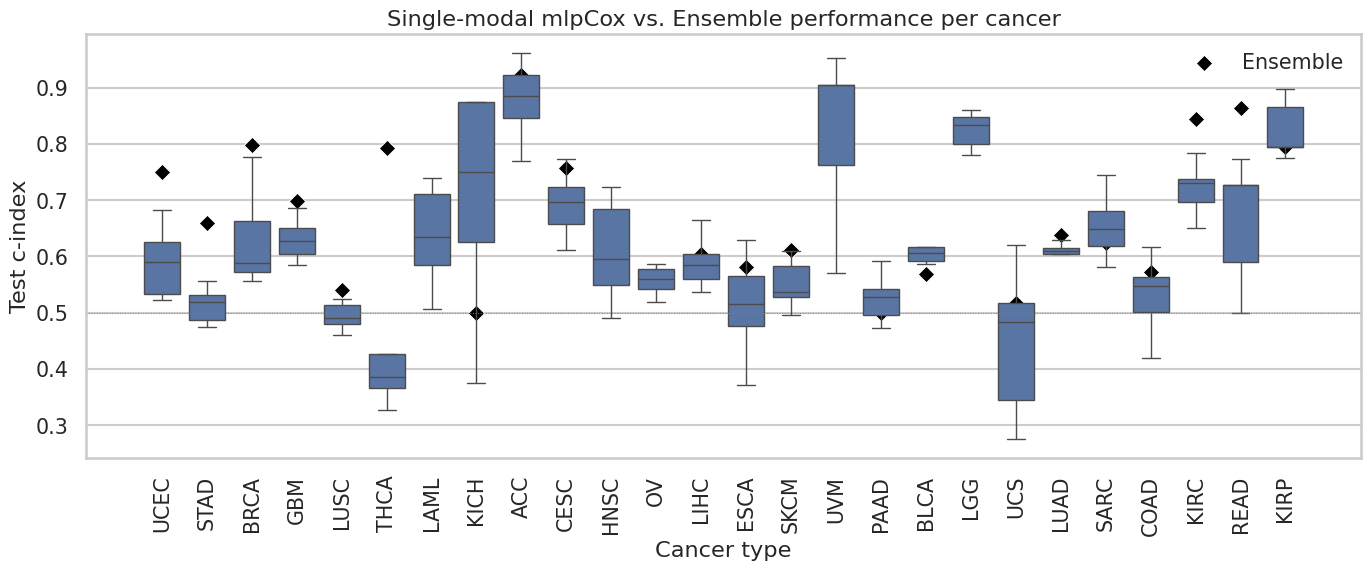

In [26]:
import json
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ─────────────────────────── user settings ───────────────────────────────────
ROOT_MLP = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/models")
ROOT_ENS = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/models")
OUT_SUB  = "EnsembleComparison"          # plots/<OUT_SUB>/
CINDEX_KEYS = ("test_cidx", "test_C", "c_index", "cindex", "concordance_index")

PALETTE_BOX = "#4C72B0"   # seaborn blue
MARKER_KW   = dict(marker="D",  # diamond
                   s=70,
                   color="black",
                   label="Ensemble")

# ─────────────────────────── helper functions ────────────────────────────────
def grab_cidx(meta: dict) -> float | None:
    for k in CINDEX_KEYS:
        if k in meta:
            return float(meta[k])
    return None

def collect_single_modal(root: Path) -> pd.DataFrame:
    rows = []
    for mjson in root.glob("*/*/metrics.json"):
        cancer, modality = mjson.parts[-3], mjson.parts[-2]
        try:
            cidx = grab_cidx(json.loads(mjson.read_text()))
            if cidx is None:
                continue
            rows.append({"cancer": cancer, "modality": modality, "cidx": cidx})
        except Exception as exc:
            print(f"⚠️  skip {mjson}: {exc}")
    return pd.DataFrame(rows)

def collect_ensemble(root: Path) -> pd.DataFrame:
    rows = []
    for mjson in root.glob("*/metrics.json"):
        cancer = mjson.parts[-2]
        try:
            cidx = grab_cidx(json.loads(mjson.read_text()))
            if cidx is None:
                continue
            rows.append({"cancer": cancer, "modality": "Ensemble", "cidx": cidx})
        except Exception as exc:
            print(f"⚠️  skip {mjson}: {exc}")
    return pd.DataFrame(rows)

# ─────────────────────────── data ingest ─────────────────────────────────────
df_mlp = collect_single_modal(ROOT_MLP)
df_ens = collect_ensemble(ROOT_ENS)

if df_mlp.empty:
    raise RuntimeError("No mlpCox metrics found – check ROOT_MLP")
if df_ens.empty:
    raise RuntimeError("No ensemble metrics found – check ROOT_ENS")

df_plot = pd.concat([df_mlp, df_ens], ignore_index=True)

# ───────────────────────── sort order (by mlp median) ────────────────────────
order_cancer = (df_mlp.groupby("cancer")["cidx"]
                        .median()
                        .sort_values(ascending=False)
                        .index)

# ──────────────────────────── plotting ───────────────────────────────────────
sns.set_style("whitegrid"); sns.set_context("talk", font_scale=0.9)
plt.figure(figsize=(14, 6))

# box-plots for single-modal runs
sns.boxplot(data=df_plot.query("modality != 'Ensemble'"),
            x="cancer", y="cidx",
            # order=order_cancer,
            color=PALETTE_BOX,
            showfliers=False)

# overlay ensemble diamonds
sns.scatterplot(data=df_plot.query("modality == 'Ensemble'"),
                x="cancer", y="cidx",
                # order=order_cancer,
                **MARKER_KW)

plt.axhline(0.5, ls=":", c="grey", lw=0.7)              # optional reference
plt.ylabel("Test c-index")
plt.xlabel("Cancer type")
plt.title("Single-modal mlpCox vs. Ensemble performance per cancer")
plt.xticks(rotation=90, ha="center")
plt.legend(frameon=False, loc="upper right")

plt.tight_layout()

# ─────────────────────────── save PDF ────────────────────────────────────────
save_fig("BoxPlusEnsemble", subdir=OUT_SUB)

print("[done]  PDF ->", ROOT_MLP.parent / "plots" / OUT_SUB)

/scratch/9913427.1.b/ipykernel_257463/111865393.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


[saved plot] /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/EnsembleComparison/BoxPlusEnsemble_bestOfFour_pinkLogic_20250822_113623.png
[info] Best ensemble strategy by cancer (top rows):
cancer          strategy   cidx
  KICH concat_nopretrain 0.6250
  LIHC concat_nopretrain 0.7080
  LUSC concat_nopretrain 0.5117
  BLCA   concat_pretrain 0.6792
  ESCA   concat_pretrain 0.7339
  KIRC   concat_pretrain 0.8298
   ACC   gate_nopretrain 0.8846
   GBM   gate_nopretrain 0.6510
  HNSC   gate_nopretrain 0.7029
  KIRP   gate_nopretrain 0.9030
  LAML   gate_nopretrain 0.7183
  SARC   gate_nopretrain 0.6804
[done] PDF saved to /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/plots/EnsembleComparison


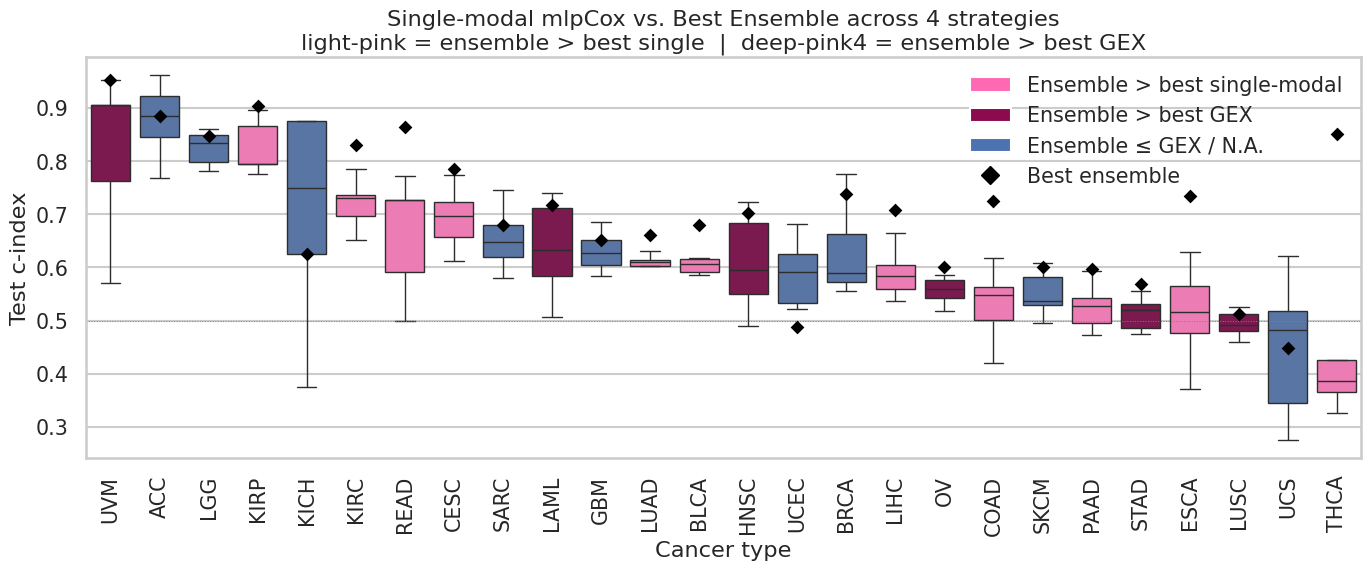

In [79]:
from pathlib import Path
import json, numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ───────── paths ─────────
ROOT_MLP = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/mlpCOX/models")
ENSEMBLE_ROOTS = [
    Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/gate_pretrain"),
    Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/gate_nopretrain"),
    Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain"),
    Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_nopretrain"),
]
OUT_SUB  = "EnsembleComparison"

# colors
DEEPPINK4 = "#8B0A50"   # your 'deeppink4'
LIGHTPINK = "#FF69B4"   # hot pink
BLUE      = "#4C72B0"

# keys that might hold the test c-index
CINDEX_KEYS = ("test_cidx", "test_C", "c_index", "cindex", "concordance_index")

# ───────── helpers ────────────
def grab_cidx(d: dict):
    for k in CINDEX_KEYS:
        if k in d:
            try: return float(d[k])
            except Exception: pass
    return None

def collect_single(root: Path) -> pd.DataFrame:
    """Single-modal mlpCOX: expect <root>/<cancer>/<modality>/metrics.json"""
    rows=[]
    for f in root.glob("*/*/metrics.json"):
        cancer, mod = f.parts[-3], f.parts[-2]
        try:
            cidx = grab_cidx(json.loads(f.read_text()))
        except Exception:
            cidx = None
        if cidx is not None:
            rows.append({"cancer": cancer, "modality": mod, "cidx": cidx})
    return pd.DataFrame(rows)

def collect_ensemble_multi(roots) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Ensemble: scan multiple roots; accept metrics.json at
      <root>/<cancer>/models/metrics.json  OR  <root>/<cancer>/models/<run>/metrics.json.
    Returns (all_rows, best_per_cancer).
    """
    rows=[]
    for r in roots:
        strategy = r.name  # e.g., 'gate_pretrain'
        if not r.exists():
            continue
        for f in r.rglob("metrics.json"):
            if "models" not in f.parts:
                continue
            try:
                i = f.parts.index("models")
                cancer = f.parts[i-1]
            except Exception:
                continue
            try:
                cidx = grab_cidx(json.loads(f.read_text()))
            except Exception:
                cidx = None
            if cidx is not None:
                rows.append({
                    "cancer": cancer,
                    "modality": "Ensemble",
                    "cidx": cidx,
                    "strategy": strategy,
                    "source_dir": str(f.parent),
                })
    df_all = pd.DataFrame(rows)
    if df_all.empty:
        return df_all, df_all
    df_best = (df_all.sort_values("cidx", ascending=False)
                    .drop_duplicates("cancer")
                    .sort_values("cancer"))
    return df_all, df_best

# ───────── ingest ─────────────
df_mlp = collect_single(ROOT_MLP)
df_ens_all, df_ens_best = collect_ensemble_multi(ENSEMBLE_ROOTS)

if df_mlp.empty:
    raise RuntimeError("No single-modal metrics found under ROOT_MLP")
if df_ens_best.empty:
    raise RuntimeError("No ensemble metrics found across ENSEMBLE_ROOTS")

# Build plotting table: single-modal + best ensemble per cancer
df = pd.concat([df_mlp, df_ens_best[["cancer","modality","cidx"]]], ignore_index=True)

# Order cancers by median single-modal c-index
order_cancer = (df_mlp.groupby("cancer")["cidx"]
                        .median()
                        .sort_values(ascending=False)
                        .index)

# Per-cancer lookups
max_single = df_mlp.groupby("cancer")["cidx"].max()                 # best single-modal
gex_score  = (df_mlp[df_mlp["modality"]=="GEX"]
              .groupby("cancer")["cidx"].max())                     # best GEX per cancer
ens_best   = df_ens_best.set_index("cancer")["cidx"]                # best ensemble (of four)

# per-cancer color:
#   LIGHTPINK if best ensemble > best single-modal
#   DEEPPINK4 if not the above but best ensemble > best GEX
#   BLUE otherwise
BOX_COLORS = []
missing_ens = []
for c in order_cancer:
    ens  = ens_best.get(c, np.nan)
    smax = max_single.get(c, np.nan)
    gex  = gex_score.get(c, np.nan)

    if not np.isnan(ens) and not np.isnan(smax) and ens > smax:
        BOX_COLORS.append(LIGHTPINK)
    elif not np.isnan(ens) and not np.isnan(gex) and ens > gex:
        BOX_COLORS.append(DEEPPINK4)
    else:
        BOX_COLORS.append(BLUE)

    if np.isnan(ens):
        missing_ens.append(c)

# ───────── plot ─────────
sns.set_style("whitegrid"); sns.set_context("talk", font_scale=0.9)
plt.figure(figsize=(14, 6))

sns.boxplot(
    data=df.query("modality != 'Ensemble'"),
    x="cancer", y="cidx",
    order=order_cancer,
    palette=BOX_COLORS,
    showfliers=False
)

sns.stripplot(
    data=df.query("modality == 'Ensemble'"),
    x="cancer", y="cidx",
    order=order_cancer,
    marker="D", size=7, color="black", linewidth=0
)

plt.axhline(0.5, ls=":", c="grey", lw=0.7)
plt.ylabel("Test c-index"); plt.xlabel("Cancer type")
plt.title("Single-modal mlpCox vs. Best Ensemble across 4 strategies\n"
          "light-pink = ensemble > best single  |  deep-pink4 = ensemble > best GEX")
plt.xticks(rotation=90, ha="center")

legend_handles = [
    Patch(facecolor=LIGHTPINK, label="Ensemble > best single-modal"),
    Patch(facecolor=DEEPPINK4, label="Ensemble > best GEX"),
    Patch(facecolor=BLUE,      label="Ensemble ≤ GEX / N.A."),
    plt.Line2D([], [], marker='D', color='black', linestyle='', label='Best ensemble'),
]
plt.legend(handles=legend_handles, frameon=False, loc="upper right")
plt.tight_layout()

# save (assumes save_fig is defined)
save_fig("BoxPlusEnsemble_bestOfFour_pinkLogic", subdir=OUT_SUB)

# Optional: which strategy won per cancer
winners = (df_ens_best[["cancer","strategy","cidx"]]
           .sort_values(["strategy","cancer"]))
print("[info] Best ensemble strategy by cancer (top rows):")
print(winners.head(12).to_string(index=False))
if missing_ens:
    print("[warn] Missing ensemble score for:", ", ".join(missing_ens))

print("[done] PDF saved to", ROOT_MLP.parent / "plots" / OUT_SUB)

In [60]:
missing = [c for c in order_cancer if c not in df_ens["cancer"].unique()]
print("No ensemble metrics for:", missing)

No ensemble metrics for: ['LUAD', 'BRCA']


In [77]:
import numpy as np
from matplotlib.patches import Patch

DEEPPINK = "#8B0A50"
LIGHTPINK = "#FF69B4"
BLUE = "#4C72B0"

# assumes df_mlp, df_ens, df, order_cancer already exist

# look-ups (robust to duplicates/missing)
max_single = df_mlp.groupby("cancer")["cidx"].max()                    # best single-modal per cancer
gex_score  = (df_mlp.loc[df_mlp["modality"] == "GEX"]
                     .set_index("cancer")["cidx"])                     # GEX per cancer
ens_score  = df_ens.groupby("cancer")["cidx"].max()                    # ensemble per cancer (use max if dups)

BOX_COLORS, missing_ens = [], []

for c in order_cancer:
    ens = ens_score.get(c, np.nan)
    smax = max_single.get(c, np.nan)
    gex = gex_score.get(c, np.nan)

    if np.isnan(ens):
        # no ensemble score for this cancer → color as baseline
        BOX_COLORS.append(BLUE)
        missing_ens.append(c)
    elif not np.isnan(smax) and ens > smax:
        BOX_COLORS.append(LIGHTPINK)   # ensemble > best single-modal
    elif not np.isnan(gex) and ens > gex:
        BOX_COLORS.append(DEEPPINK)    # ensemble > GEX
    else:
        BOX_COLORS.append(BLUE)        # ≤ GEX (or insufficient info)

# ───────── plot ─────────
sns.set_style("whitegrid"); sns.set_context("talk", font_scale=0.9)
plt.figure(figsize=(14, 6))

sns.boxplot(
    data=df.query("modality != 'Ensemble'"),
    x="cancer", y="cidx",
    order=order_cancer,
    palette=BOX_COLORS,    # list aligned to order
    showfliers=False
)

sns.stripplot(
    data=df.query("modality == 'Ensemble'"),
    x="cancer", y="cidx",
    order=order_cancer,
    marker="D", size=7, color="black", linewidth=0, label="Ensemble"
)

plt.axhline(0.5, ls=":", c="grey", lw=0.7)
plt.ylabel("Test c-index"); plt.xlabel("Cancer type")
plt.title(
    "mlpCox modalities vs. Ensemble\n"
    "light-pink = ensemble > max single  |  deep-pink = ensemble > GEX"
)
plt.xticks(rotation=90, ha="center")

legend_handles = [
    Patch(facecolor=LIGHTPINK, label="Ensemble > max single-modal"),
    Patch(facecolor=DEEPPINK, label="Ensemble > GEX"),
    Patch(facecolor=BLUE,     label="Ensemble ≤ GEX / N.A."),
    plt.Line2D([], [], marker='D', color='black', linestyle='', label='Ensemble score'),
]
plt.legend(handles=legend_handles, frameon=False, loc="upper right")

plt.tight_layout()
save_fig("BoxPlusEnsemble_colorLogic", subdir=OUT_SUB)

if missing_ens:
    print("[WARN] No ensemble score for:", ", ".join(missing_ens))

print("[done] PDF saved to", ROOT_MLP.parent / "plots" / OUT_SUB)

UndefinedVariableError: name 'modality' is not defined

<Figure size 1400x600 with 0 Axes>

cancer  fusion    pretrain  test_C
0     UVM    gate  nopretrain  0.9524
1    KIRP    gate  nopretrain  0.9030
2     ACC    gate  nopretrain  0.8846
3    READ    gate    pretrain  0.8636
4    THCA    gate    pretrain  0.8515
5     LGG    gate    pretrain  0.8472
6    KIRC  concat    pretrain  0.8298
7    CESC    gate    pretrain  0.7846
8    BRCA  concat  nopretrain  0.7381
9    ESCA  concat    pretrain  0.7339
10   COAD    gate    pretrain  0.7243
11   LAML    gate  nopretrain  0.7183
12   LIHC  concat  nopretrain  0.7080
13   HNSC    gate  nopretrain  0.7029
14   SARC    gate  nopretrain  0.6804
15   BLCA  concat    pretrain  0.6792
16   LUAD    gate    pretrain  0.6613
17    GBM    gate  nopretrain  0.6510
18   KICH  concat  nopretrain  0.6250
19   SKCM    gate  nopretrain  0.6012
20     OV    gate    pretrain  0.6004
21   PAAD    gate    pretrain  0.5972
22   STAD    gate  nopretrain  0.5680
23   LUSC  concat  nopretrain  0.5117
24   UCEC    gate  nopretrain  0.4886
25    UCS    gate    pretrain  0.4483

/scratch/9913427.1.b/ipykernel_257463/2465077248.py:65: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(data=df, x="fusion", y="test_C", hue="pretrain",


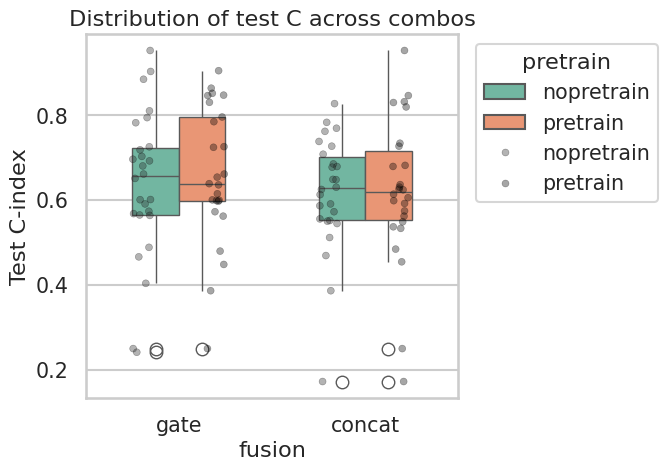

In [76]:
import json, warnings
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = Path("/projectnb2/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo")

COMBOS = [
    ("gate",   "pretrain"),
    ("gate",   "nopretrain"),
    ("concat", "pretrain"),
    ("concat", "nopretrain"),
]

def load_metrics(root: Path) -> pd.DataFrame:
    rows = []
    for fusion, pt in COMBOS:
        combo_dir = root / f"{fusion}_{pt}"
        if not combo_dir.exists():
            warnings.warn(f"[skip] {combo_dir} not found")
            continue

        for meta in combo_dir.rglob("metrics.json"):
            # accept only files **inside** a models directory, no matter how deep
            if "models" not in meta.parts:
                continue
            try:
                m = json.load(open(meta))
                rows.append({
                    "cancer":   m.get("cancer", "UNKNOWN"),
                    "fusion":   fusion,
                    "pretrain": pt,
                    "dev_C":    m.get("dev_C", float("nan")),
                    "test_C":   m.get("test_C", float("nan")),
                    "run_path": str(meta.parent.parent),   # models/.. = run root
                    "timestamp": m.get("timestamp", ""),
                })
            except Exception as ex:
                warnings.warn(f"[bad] {meta}: {ex}")
    return pd.DataFrame(rows)

df_raw = load_metrics(ROOT)
if df_raw.empty:
    raise RuntimeError("No metrics found – maybe jobs still running?")

# ── keep best test‑C for each (cancer,fusion,pretrain) ──
df = (df_raw.sort_values("test_C", ascending=False)
             .groupby(["cancer","fusion","pretrain"])
             .head(1)
             .reset_index(drop=True))

# ── best combo per cancer ──
best = (df.sort_values("test_C", ascending=False)
          .groupby("cancer")
          .head(1)
          .reset_index(drop=True))

display(best[["cancer","fusion","pretrain","test_C"]])

plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="fusion", y="test_C", hue="pretrain",
            width=.5, showcaps=False, palette="Set2")
sns.stripplot(data=df, x="fusion", y="test_C", hue="pretrain",
              dodge=True, alpha=.35, color="k", linewidth=.4)
plt.ylabel("Test C‑index")
plt.title("Distribution of test C across combos")
plt.legend(title="pretrain", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

26 cancers have all 4 combos.


cancer  fusion    pretrain   dev_C  test_C            timestamp  \
0    UVM    gate  nopretrain  0.8696  0.9524  2025-08-16T12:42:35   
1    UVM  concat    pretrain  0.8841  0.9524  2025-08-18T19:24:27   
2    UVM    gate    pretrain  0.8986  0.9048  2025-08-18T19:24:23   
3   KIRP    gate  nopretrain  0.7915  0.9030  2025-08-16T12:46:43   
4    ACC    gate  nopretrain  0.9219  0.8846  2025-08-14T18:45:34   

                                            run_path            combo  
0  /projectnb2/evolution/zwakefield/tcga/sir_anal...  gate-nopretrain  
1  /projectnb2/evolution/zwakefield/tcga/sir_anal...  concat-pretrain  
2  /projectnb2/evolution/zwakefield/tcga/sir_anal...    gate-pretrain  
3  /projectnb2/evolution/zwakefield/tcga/sir_anal...  gate-nopretrain  
4  /projectnb2/evolution/zwakefield/tcga/sir_anal...  gate-nopretrain


=== Summary per combo (test C) ===


median      mean       iqr   n
combo                                             
gate-nopretrain    0.65615  0.637215  0.158100  26
gate-pretrain      0.63860  0.658936  0.198500  25
concat-nopretrain  0.62765  0.615873  0.149525  26
concat-pretrain    0.61900  0.620942  0.163475  26


Wins per combo (# cancers where it’s best):


wins
combo                  
gate-nopretrain       9
gate-pretrain         9
concat-nopretrain     4
concat-pretrain       4


Average rank (1 = best):


avg_rank
combo                      
gate-pretrain      2.100000
gate-nopretrain    2.346154
concat-nopretrain  2.711538
concat-pretrain    2.769231


=== Paired Wilcoxon (test_C), only cancers with all 4 combos ===
gate-nopretrain vs gate-pretrain: p=nan (stat=nan)
gate-nopretrain vs concat-nopretrain: p=0.211 (stat=116.0)
gate-nopretrain vs concat-pretrain: p=0.52 (stat=127.5)
gate-pretrain vs concat-nopretrain: p=nan (stat=nan)
gate-pretrain vs concat-pretrain: p=nan (stat=nan)
concat-nopretrain vs concat-pretrain: p=0.689 (stat=136.0)


/scratch/9913427.1.b/ipykernel_257463/414888026.py:104: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df4, x="cancer", y="test_C", hue="combo",


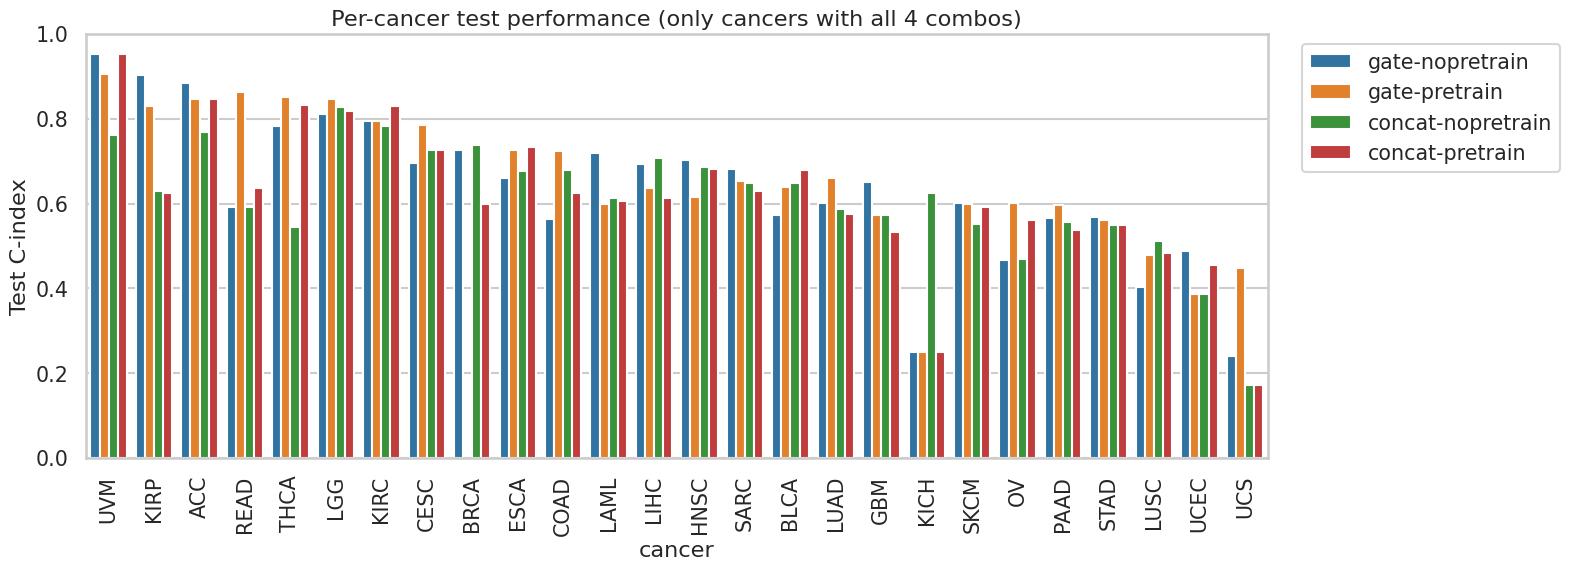

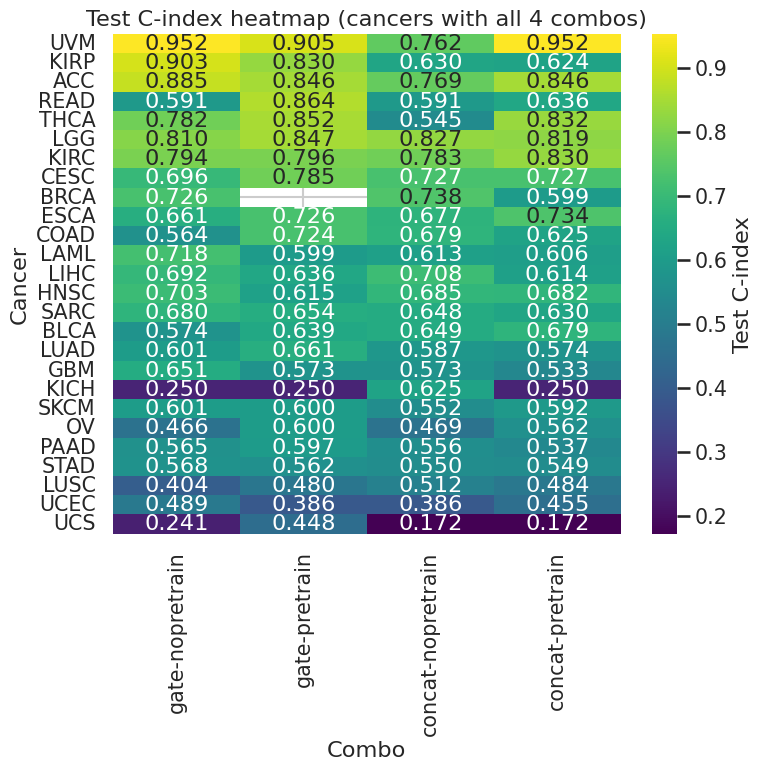

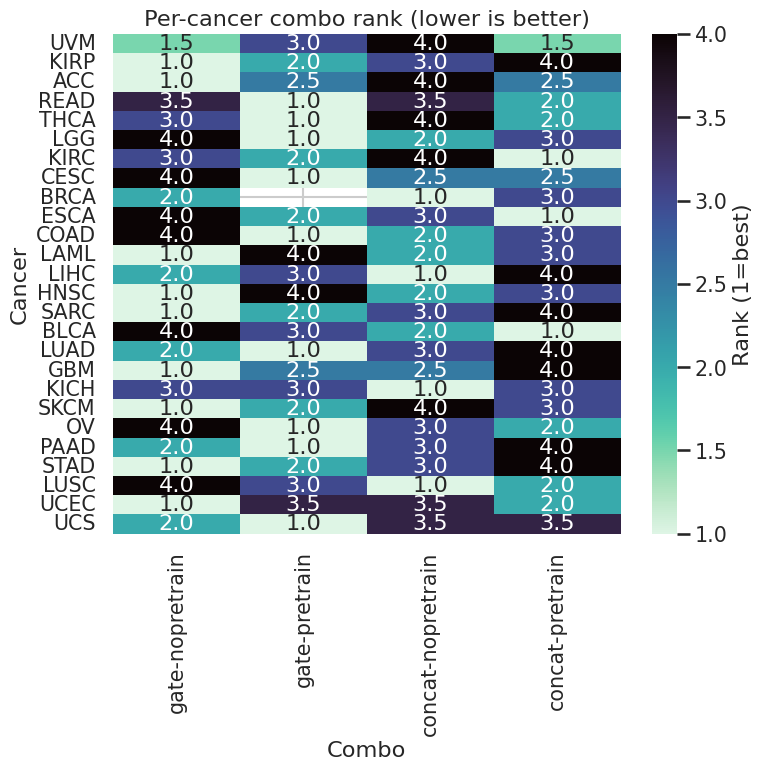

In [75]:
import json, warnings
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from scipy.stats import wilcoxon
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

ROOT = Path("/projectnb2/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo")
COMBOS = [
    ("gate",   "pretrain"),
    ("gate",   "nopretrain"),
    ("concat", "pretrain"),
    ("concat", "nopretrain"),
]

def load_metrics(root: Path) -> pd.DataFrame:
    rows = []
    for fusion, pt in COMBOS:
        combo_dir = root / f"{fusion}_{pt}"
        if not combo_dir.exists():
            warnings.warn(f"[skip] {combo_dir} not found")
            continue
        for meta in combo_dir.rglob("metrics.json"):
            if "models" not in meta.parts:
                continue
            try:
                m = json.load(open(meta))
                rows.append({
                    "cancer":   m.get("cancer", "UNKNOWN"),
                    "fusion":   fusion,
                    "pretrain": pt,
                    "dev_C":    m.get("dev_C", np.nan),
                    "test_C":   m.get("test_C", np.nan),
                    "timestamp": m.get("timestamp", ""),
                    "run_path": str(meta.parent.parent),
                })
            except Exception as ex:
                warnings.warn(f"[bad] {meta}: {ex}")
    return pd.DataFrame(rows)

# 1) Load + keep best (highest test_C) per (cancer, combo)
df_raw = load_metrics(ROOT)
assert not df_raw.empty, "No metrics found"

df_best_combo = (df_raw.sort_values("test_C", ascending=False)
                        .groupby(["cancer","fusion","pretrain"])
                        .head(1)
                        .reset_index(drop=True))

df_best_combo["combo"] = df_best_combo["fusion"] + "-" + df_best_combo["pretrain"]

# 2) Keep cancers that have all 4 combos
counts = df_best_combo.groupby("cancer")["combo"].nunique()
keep_cancers = counts[counts >= 2].index
df4 = df_best_combo[df_best_combo["cancer"].isin(keep_cancers)].copy()

print(f"{len(keep_cancers)} cancers have all 4 combos.")
display(df4.head())

# 3) Summary stats per combo
summary = (
    df4.groupby("combo")["test_C"]
       .agg(median="median", mean="mean",
            iqr=lambda s: s.quantile(0.75)-s.quantile(0.25),
            n="count")
       .sort_values("median", ascending=False)
)
print("\n=== Summary per combo (test C) ===")
display(summary)

# wins & avg ranks
pivot = df4.pivot_table(index="cancer", columns="combo", values="test_C")
wins = pivot.idxmax(axis=1).value_counts().reindex(summary.index, fill_value=0)
ranks = pivot.rank(axis=1, ascending=False, method="average")
avg_rank = ranks.mean().reindex(summary.index)

print("\nWins per combo (# cancers where it’s best):")
display(wins.to_frame("wins"))

print("\nAverage rank (1 = best):")
display(avg_rank.to_frame("avg_rank").sort_values("avg_rank"))

# 4) Pairwise Wilcoxon tests (optional)
if HAVE_SCIPY:
    print("\n=== Paired Wilcoxon (test_C), only cancers with all 4 combos ===")
    combos = summary.index.tolist()
    for i in range(len(combos)):
        for j in range(i+1, len(combos)):
            a, b = combos[i], combos[j]
            stat, p = wilcoxon(pivot[a], pivot[b])
            print(f"{a} vs {b}: p={p:.3g} (stat={stat})")
else:
    print("\n(Scipy not available → skipping Wilcoxon tests)")

# 5) Grouped bar plot (side-by-side)
plt.figure(figsize=(16,6))
order_cancers = pivot.max(1).sort_values(ascending=False).index  # sort by best C
sns.barplot(data=df4, x="cancer", y="test_C", hue="combo",
            order=order_cancers, hue_order=summary.index, ci=None)
plt.xticks(rotation=90)
plt.ylabel("Test C-index")
plt.title("Per-cancer test performance (only cancers with all 4 combos)")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

# 6) Heatmap of C-indices
plt.figure(figsize=(8, max(8, 0.3*len(order_cancers))))
sns.heatmap(pivot.loc[order_cancers, summary.index],
            annot=True, fmt=".3f", cmap="viridis",
            cbar_kws={"label": "Test C-index"})
plt.title("Test C-index heatmap (cancers with all 4 combos)")
plt.xlabel("Combo")
plt.ylabel("Cancer")
plt.tight_layout()
plt.show()

# 7) Rank heatmap (who wins where)
plt.figure(figsize=(8, max(8, 0.3*len(order_cancers))))
sns.heatmap(ranks.loc[order_cancers, summary.index],
            annot=True, fmt=".1f", cmap="mako_r",
            cbar_kws={"label": "Rank (1=best)"})
plt.title("Per-cancer combo rank (lower is better)")
plt.xlabel("Combo")
plt.ylabel("Cancer")
plt.tight_layout()
plt.show()

/scratch/9913427.1.b/ipykernel_257463/78162878.py:73: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(data=shap_df, x="modality", y="prop", hue="combo",


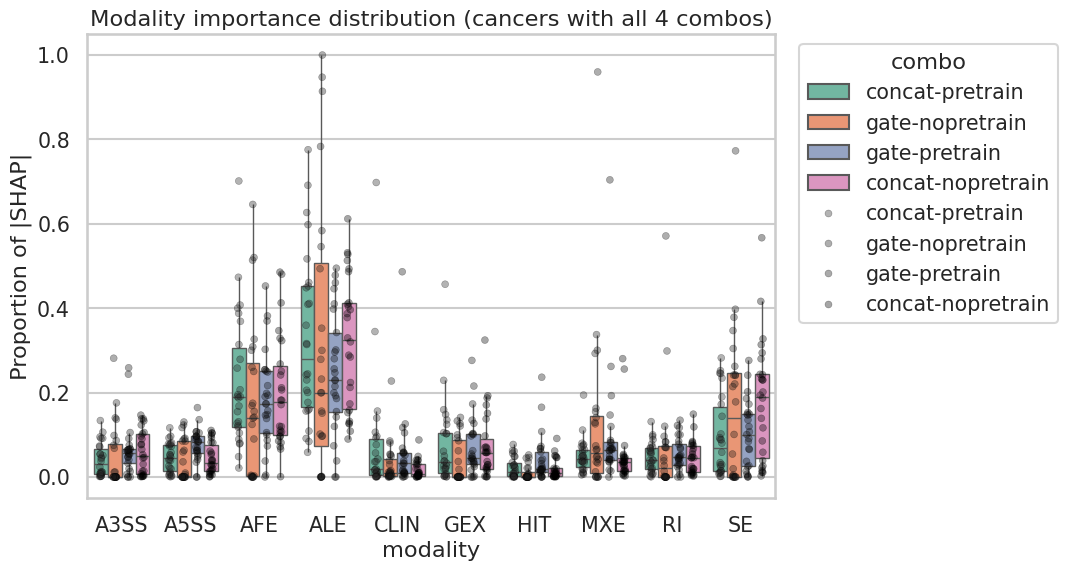

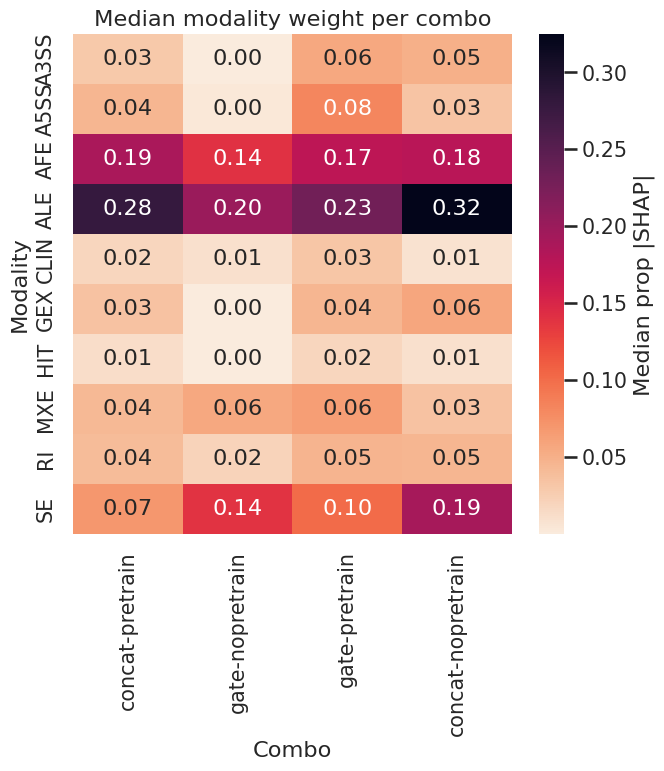

In [69]:
import warnings, json
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = Path("/projectnb2/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo")
SHAP_FILE = "shap_mean_abs.csv"

COMBOS = {
    ("gate","pretrain"):   "gate-pretrain",
    ("gate","nopretrain"): "gate-nopretrain",
    ("concat","pretrain"): "concat-pretrain",
    ("concat","nopretrain"):"concat-nopretrain",
}

# -----------------------------------------------------------------
def find_shap_file(combo_dir: Path, cancer: str) -> Path | None:
    """
    Returns the path of shap_mean_abs.csv for this cancer+combo
    taking into account odd duplicates like  …/ACC/ACC/shap/ACC/…
    """
    # most common pattern
    cand = combo_dir / cancer / "shap" / cancer / SHAP_FILE
    if cand.exists():
        return cand

    # fallback: any shap_mean_abs.csv that lives under a "shap" dir and
    # whose path contains the cancer name
    for fp in combo_dir.rglob(SHAP_FILE):
        if "shap" in fp.parts and cancer in fp.parts:
            return fp
    return None
# -----------------------------------------------------------------
def modality_of(feature: str):
    tag = feature.split("::")[0]
    return tag if tag in [
        "GEX", "CLIN", "HIT",
        "AFE","ALE","MXE","SE","RI","A3SS","A5SS"
    ] else "OTHER"

rows = []
for _, row in df4.iterrows():
    fusion, pre = row["fusion"], row["pretrain"]
    combo_dir   = ROOT / f"{fusion}_{pre}"
    shap_path   = find_shap_file(combo_dir, row["cancer"])
    if shap_path is None:
        warnings.warn(f"[miss] SHAP file not found for {row['cancer']} {row['combo']}")
        continue

    tmp = pd.read_csv(shap_path, index_col=0)
    s   = tmp.iloc[:, 0] if tmp.shape[1] == 1 else tmp.squeeze("columns")
    tot = s.abs().sum()
    if tot == 0 or tot is np.nan:
        continue
    mod_prop = s.groupby(modality_of).apply(lambda v: v.abs().sum()) / tot
    for mod, prop in mod_prop.items():
        rows.append({
            "cancer":   row["cancer"],
            "combo":    row["combo"],
            "modality": mod,
            "prop":     prop,
        })

shap_df = pd.DataFrame(rows)
if shap_df.empty:
    raise RuntimeError("No SHAP data collected – check paths or job status")

# ───────────────── visualisations ───────────────────────────────
plt.figure(figsize=(11,6))
sns.boxplot(data=shap_df, x="modality", y="prop", hue="combo",
            showcaps=False, fliersize=0, palette="Set2")
sns.stripplot(data=shap_df, x="modality", y="prop", hue="combo",
              dodge=True, alpha=.35, color="k", linewidth=.4)
plt.ylabel("Proportion of |SHAP|")
plt.title("Modality importance distribution (cancers with all 4 combos)")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", title="combo")
plt.tight_layout()
plt.show()

median_prop = (shap_df.groupby(["modality","combo"])["prop"]
                       .median()
                       .unstack("combo")
                       .fillna(0)
                       .loc[:, shap_df["combo"].unique()])   # keep col‑order

plt.figure(figsize=(7,8))
sns.heatmap(median_prop, annot=True, fmt=".2f",
            cmap="rocket_r", cbar_kws={"label": "Median prop |SHAP|"})
plt.title("Median modality weight per combo")
plt.xlabel("Combo"); plt.ylabel("Modality")
plt.tight_layout()
plt.show()

/scratch/9913427.1.b/ipykernel_257463/1787876462.py:49: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(data=shap_df, x="modality", y="prop", hue="combo",


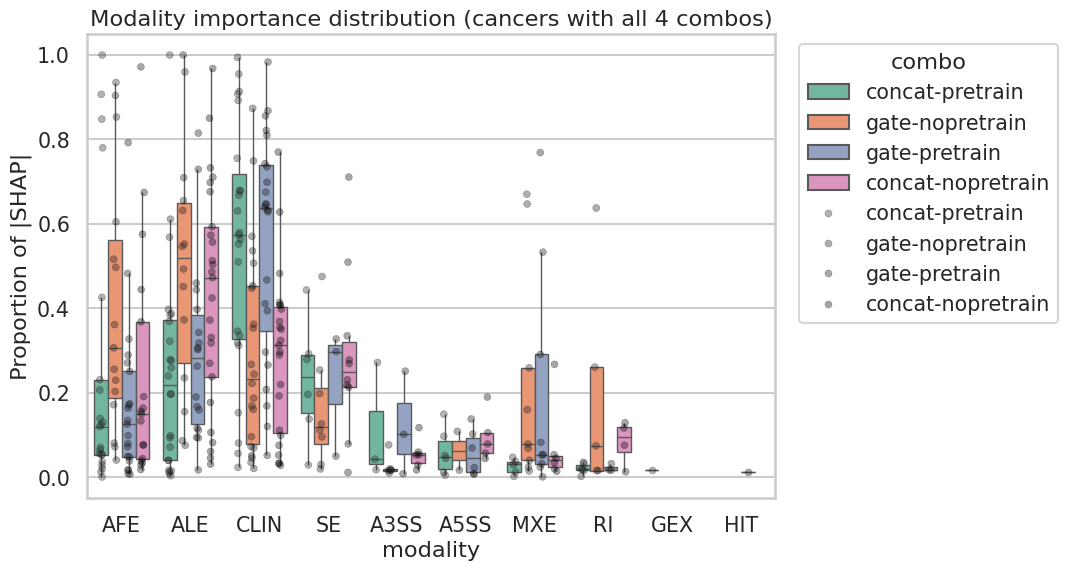

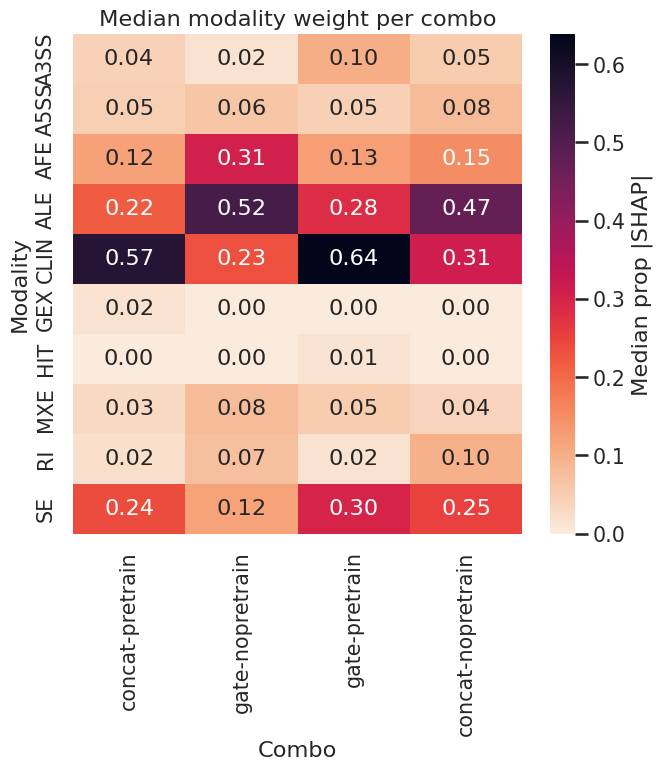

In [74]:
TOPK = 50

rows = []
missing = []
for _, row in df4.iterrows():
    shap_path = Path(row["run_path"]) / "shap" / SHAP_FILE
    
    if not shap_path.exists():
        missing.append((row["cancer"], row["combo"]))
        continue

    # TOPK = 150
    # s = pd.read_csv(shap_path, index_col=0).iloc[:,0]
    # mod_all  = s.groupby(modality_of).apply(lambda v: v.abs().sum())
    # mod_topk = s.abs().sort_values(ascending=False).head(TOPK) \
    #                  .groupby(modality_of).apply(lambda v: v.abs().sum())
    
    # print("ALL:", (mod_all / mod_all.sum()).round(3))
    # print("TOPK:", (mod_topk / mod_topk.sum()).round(3))

    tmp = pd.read_csv(shap_path, index_col=0)
    s   = tmp.iloc[:, 0] if tmp.shape[1] == 1 else tmp.squeeze("columns")

    # ---- keep only top-K by |SHAP| ---------------------------------------
    top_idx = s.abs().sort_values(ascending=False).head(TOPK).index
    s_top   = s.loc[top_idx]

    tot = s_top.abs().sum()
    if tot == 0 or np.isnan(tot):
        continue

    mod_prop = s_top.groupby(modality_of).apply(lambda v: v.abs().sum()) / tot
    for mod, prop in mod_prop.items():
        rows.append({
            "cancer":   row["cancer"],
            "combo":    row["combo"],
            "modality": mod,
            "prop":     prop,
        })

shap_df = pd.DataFrame(rows)
if shap_df.empty:
    raise RuntimeError("No SHAP data collected – check paths or job status")

# ───────────────── visualisations ───────────────────────────────
plt.figure(figsize=(11,6))
sns.boxplot(data=shap_df, x="modality", y="prop", hue="combo",
            showcaps=False, fliersize=0, palette="Set2")
sns.stripplot(data=shap_df, x="modality", y="prop", hue="combo",
              dodge=True, alpha=.35, color="k", linewidth=.4)
plt.ylabel("Proportion of |SHAP|")
plt.title("Modality importance distribution (cancers with all 4 combos)")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", title="combo")
plt.tight_layout()
plt.show()

median_prop = (shap_df.groupby(["modality","combo"])["prop"]
                       .median()
                       .unstack("combo")
                       .fillna(0)
                       .loc[:, shap_df["combo"].unique()])   # keep col‑order

plt.figure(figsize=(7,8))
sns.heatmap(median_prop, annot=True, fmt=".2f",
            cmap="rocket_r", cbar_kws={"label": "Median prop |SHAP|"})
plt.title("Median modality weight per combo")
plt.xlabel("Combo"); plt.ylabel("Modality")
plt.tight_layout()
plt.show()

In [73]:
from pathlib import Path
import json

root = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo")
strategies = ["concat_pretrain", "gate_pretrain", "concat_nopretrain", "gate_nopretrain"]

unfinished = []
checked = 0

def check_metrics_file(mpath: Path, label: str):
    """Return (is_ok, reason_if_bad)."""
    if not mpath.exists():
        return False, "metrics.json missing"
    try:
        if mpath.stat().st_size == 0:
            return False, "metrics.json empty"
        with mpath.open() as fh:
            json.load(fh)
        return True, ""
    except Exception as e:
        return False, f"metrics.json invalid: {e.__class__.__name__}"

for strat in strategies:
    strat_dir = root / strat
    if not strat_dir.exists():
        print(f"[WARN] Strategy dir missing: {strat_dir}")
        continue

    for cancer_dir in strat_dir.iterdir():
        if not cancer_dir.is_dir():
            continue

        models_dir = cancer_dir / "models"
        if not models_dir.exists():
            print(f"[WARN] No models/ in {cancer_dir}")
            continue

        # Detect layout: either metrics.json sits directly in models/,
        # OR there are per-run subdirs under models/.
        subdirs = [p for p in models_dir.iterdir() if p.is_dir()]
        if not subdirs:
            # Treat models/ itself as a single run
            checked += 1
            ok, reason = check_metrics_file(models_dir / "metrics.json", f"{strat}/{cancer_dir.name}")
            if not ok:
                unfinished.append({
                    "strategy": strat,
                    "cancer": cancer_dir.name,
                    "run_dir": str(models_dir),
                    "reason": reason
                })
        else:
            # Per-run subdirectories
            for run_dir in sorted(subdirs):
                checked += 1
                ok, reason = check_metrics_file(run_dir / "metrics.json", f"{strat}/{cancer_dir.name}/{run_dir.name}")
                if not ok:
                    unfinished.append({
                        "strategy": strat,
                        "cancer": cancer_dir.name,
                        "run_dir": str(run_dir),
                        "reason": reason
                    })

print(f"\nScanned {checked} model run {'directory' if checked==1 else 'directories'}.")
print(f"Unfinished: {len(unfinished)}")

if unfinished:
    print("\n--- Unfinished model runs ---")
    for u in unfinished:
        print(f"[{u['strategy']}] {u['cancer']} :: {u['run_dir']} -> {u['reason']}")


Scanned 132 model run directories.
Unfinished: 29

--- Unfinished model runs ---
[concat_pretrain] DLBC :: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/DLBC/models -> metrics.json missing
[concat_pretrain] PRAD :: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/PRAD/models -> metrics.json missing
[concat_pretrain] THYM :: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/THYM/models -> metrics.json missing
[concat_pretrain] MESO :: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/MESO/models -> metrics.json missing
[concat_pretrain] TGCT :: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/TGCT/models -> metrics.json missing
[concat_pretrain] CHOL :: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ens

In [72]:
# EXPECTS: a list `unfinished` with dicts like:
# {"strategy": "concat_pretrain"|"gate_pretrain", "cancer": "BRCA", ...}

CANCERS = [
  "ACC","BLCA","BRCA","CESC","CHOL","COAD","DLBC","ESCA","GBM","HNSC",
  "KICH","KIRC","KIRP","LAML","LGG","LIHC","LUAD","LUSC","MESO","OV",
  "PAAD","PCPG","PRAD","READ","SARC","SKCM","STAD","TGCT","THCA","THYM",
  "UCEC","UCS","UVM",
]
cancer2idx = {c: i+1 for i, c in enumerate(CANCERS)}

def fusion_to_combo_idx(strategy):
    # gate_pretrain -> 0, concat_pretrain -> 1
    return 0 if strategy.startswith("gate") else 1

task_ids = []
for u in unfinished:
    cidx = cancer2idx[u["cancer"]]
    combo_idx = fusion_to_combo_idx(u["strategy"])
    tid = (cidx - 1)*2 + combo_idx + 1
    task_ids.append(tid)

# de-dup and compact for qsub -t
task_ids = sorted(set(task_ids))

# Print as a comma-separated list and as ranges (e.g., 5,8,12-14)
def to_ranges(nums):
    if not nums: return ""
    ranges = []
    start = prev = nums[0]
    for n in nums[1:]:
        if n == prev + 1:
            prev = n
            continue
        ranges.append((start, prev))
        start = prev = n
    ranges.append((start, prev))
    parts = [f"{a}" if a==b else f"{a}-{b}" for a,b in ranges]
    return ",".join(parts)

print("TASK LIST (comma/ranges):", to_ranges(task_ids))
print("TASK LIST (raw):", ",".join(map(str, task_ids)))

TASK LIST (comma/ranges): 5,9-10,13-14,33,37-38,43-46,55-56,59-60
TASK LIST (raw): 5,9,10,13,14,33,37,38,43,44,45,46,55,56,59,60


In [40]:
from pathlib import Path

root = Path("/projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo")

for strat in ["concat_pretrain", "gate_pretrain"]:
    strat_dir = root / strat
    if not strat_dir.exists():
        print(f"[MISSING STRATEGY] {strat_dir}")
        continue
    print(f"\n--- Strategy: {strat} ---")
    for path in strat_dir.rglob("*"):
        if path.is_dir() and path.name == "models":
            print("Found models/:", path)


--- Strategy: concat_pretrain ---
Found models/: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/UCEC/models
Found models/: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/STAD/models
Found models/: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/BRCA/models
Found models/: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/GBM/models
Found models/: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/DLBC/models
Found models/: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/PRAD/models
Found models/: /projectnb/evolution/zwakefield/tcga/sir_analysis/survivalModel/ensemble/results_combo/concat_pretrain/THYM/models
Found models/: /projectnb/evolution/zwakefield/tcga/sir_